# Analyze Representations in Path-Integrating RNN

Model from "Conformal Isometry of Lie Group Representation in Recurrent Network of Grid Cells" Xu, et al. 2022. (https://arxiv.org/abs/2210.02684)

### Set Up + Imports

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt


import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import torch

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


### Load trained model config, activations, loss

In [2]:
from neurometry.datasets.load_rnn_grid_cells import load_rate_maps, load_config

# run_id = "20240418-180712"
run_id = "20240504-020404"
step_before = 25000
step_after = 30000

activations_before = load_rate_maps(run_id, step_before)
activations_after = load_rate_maps(run_id, step_after)

config = load_config(run_id)

2024-05-18 19:10:24.685062: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 19:10:25.335063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Visualize rate maps

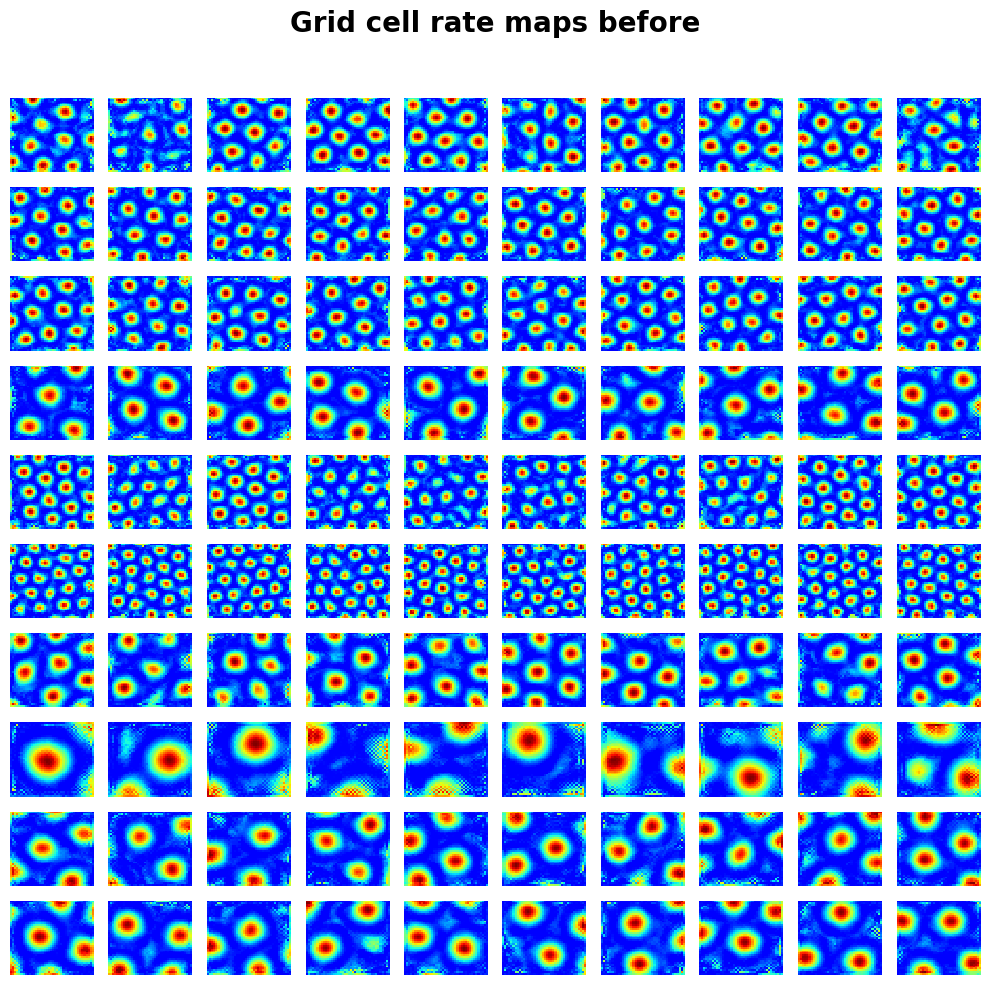

In [3]:
from neurometry.datasets.load_rnn_grid_cells import draw_heatmap

block_size = config["model"]["block_size"]
num_grid = config["model"]["num_grid"]

draw_heatmap(
    activations_before["v"].reshape(-1, block_size, num_grid, num_grid)[:10, :10],
    title="Grid cell rate maps before",
);

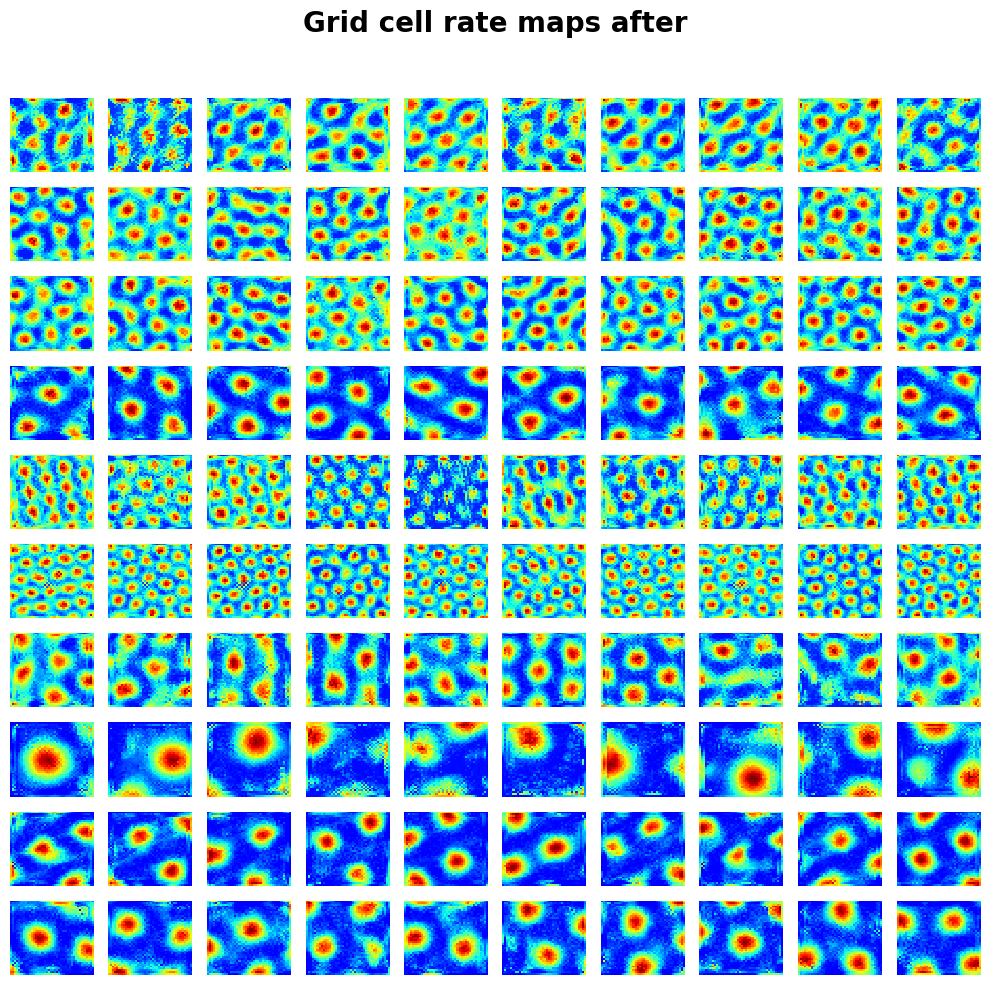

In [4]:
draw_heatmap(
    activations_after["v"].reshape(-1, block_size, num_grid, num_grid)[:10, :10],
    title="Grid cell rate maps after",
);

Visualize total loss through training

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


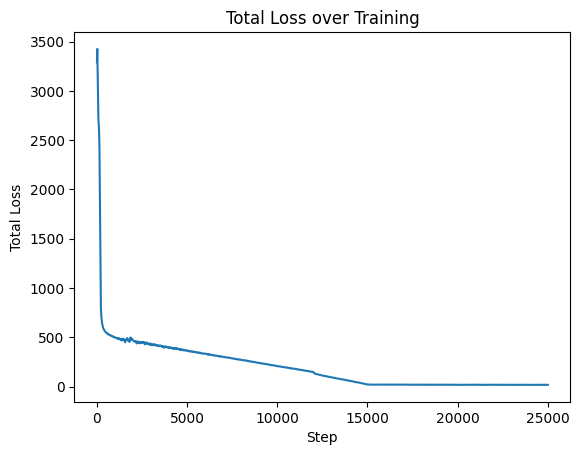

In [5]:
from neurometry.datasets.load_rnn_grid_cells import extract_tensor_events

run_dir = os.path.join(
    os.getcwd(),
    "curvature/grid-cells-curvature/models/xu_rnn/logs/rnn_isometry/20240418-180712",
)

event_file = os.path.join(run_dir, "events.out.tfevents.1713488846.hall.2392205.0.v2")
all_tensor_data, losses = extract_tensor_events(event_file, verbose=False)

loss_vals = [l["loss"] for l in losses]
loss_steps = [l["step"] for l in losses]

plt.plot(loss_steps, loss_vals)
plt.xlabel("Step")
plt.ylabel("Total Loss")
plt.title("Total Loss over Training");

### Compute grid scores, spatial autocorrelations (SACs)

In [6]:
from neurometry.datasets.load_rnn_grid_cells import get_scores

scores = get_scores(run_dir, activations_before, config)

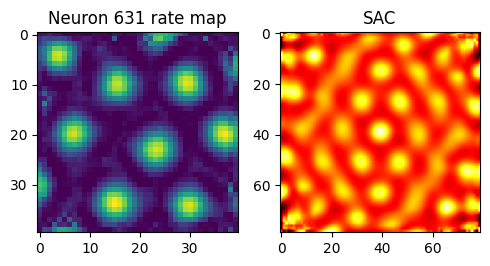

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

cell_id = 631

axes[0].imshow(activations_before["v"][cell_id])
axes[0].set_title(f"Neuron {cell_id} rate map")
axes[1].imshow(scores["sac"][cell_id], cmap="hot")
axes[1].set_title("SAC")
plt.tight_layout()

### Compute 2D fourier transform of the rate maps

In [55]:
# from scipy.fftpack import fft2, fftshift

# fft_rate_maps = np.array([fftshift(fft2(rate_map)) for rate_map in activations["v"]])

# # visualize the 2D fourier transform of the rate map for a single cell

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# cell_id = 201

# axes[0].imshow(np.abs(fft_rate_maps[cell_id]), cmap="hot")
# axes[1].imshow(activations["v"][cell_id])

# # estimate the spectral density of the rate maps

# from scipy.signal import welch

# frequencies, psd = welch(activations["v"], fs=40, nperseg=40, axis=1)

# # visualize the spectral density of the rate maps for a single cell

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# cell_id = 201

# axes[0].plot(frequencies, psd[cell_id])

# axes[1].imshow(activations["v"][cell_id]);

In [56]:
# plt.hist(scale_tensor, bins=20);

### Define subpolations based on UMAP on spatial autocorrelation scores

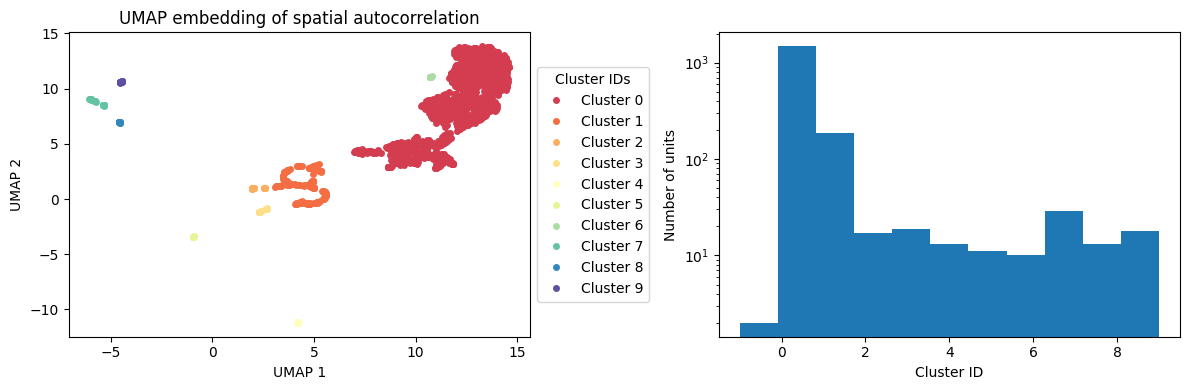

In [8]:
from neurometry.datasets.load_rnn_grid_cells import umap_dbscan

clusters_before, umap_cluster_labels = umap_dbscan(
    activations_before["v"], run_dir, config, sac_array=None, plot=True
)

There are 29 units in cluster 7


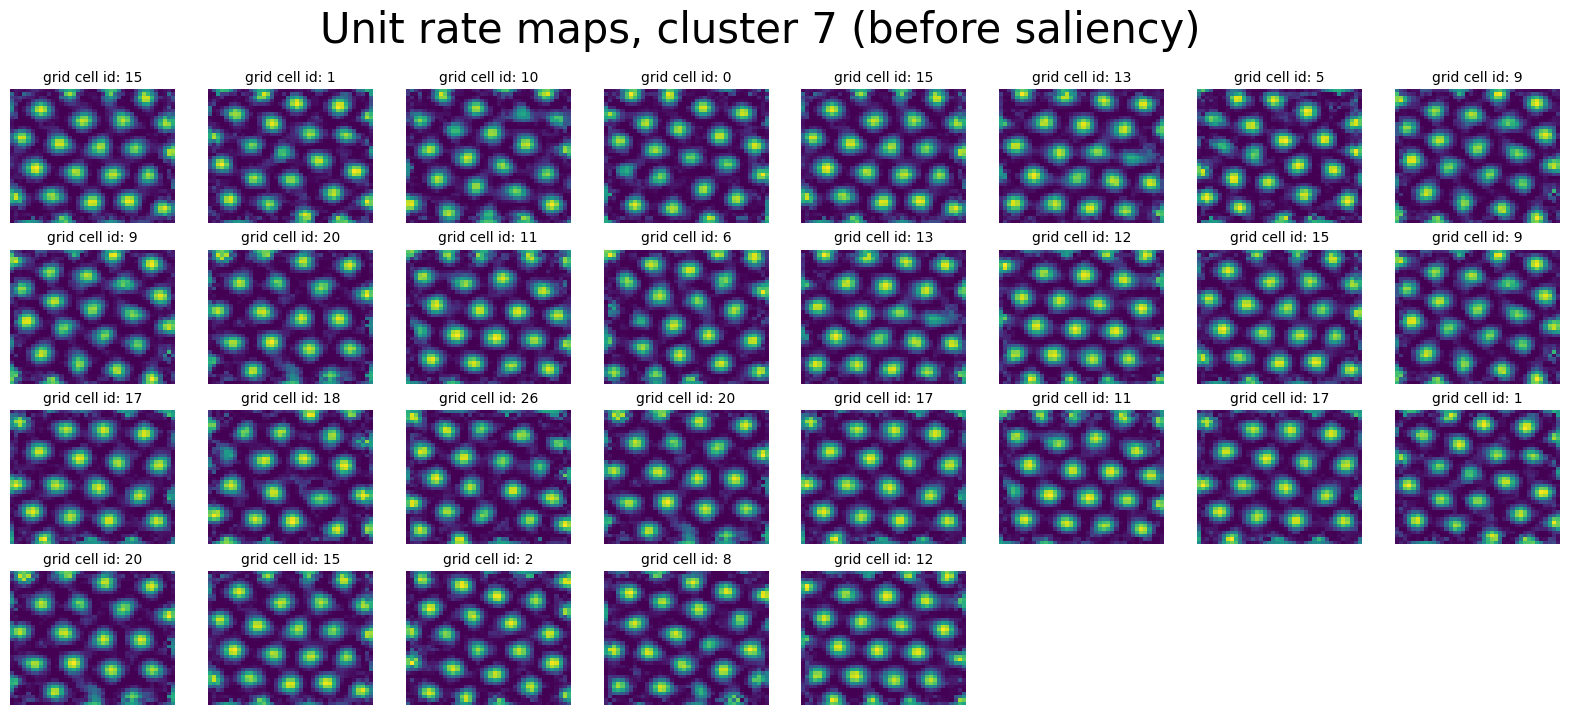

In [9]:
from neurometry.datasets.load_rnn_grid_cells import plot_rate_map

cluster_id = 7

num_cells_in_cluster = clusters_before[cluster_id].shape[0]
print(f"There are {num_cells_in_cluster} units in cluster {cluster_id}")

plot_rate_map(
    None,
    min(40, num_cells_in_cluster),
    clusters_before[cluster_id],
    f"Unit rate maps, cluster {cluster_id} (before saliency)",
)

neural_points_before = (
    clusters_before[cluster_id].reshape(len(clusters_before[cluster_id]), -1).T
)

In [17]:
clusters_before.keys()

dict_keys([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

(1600, 29)


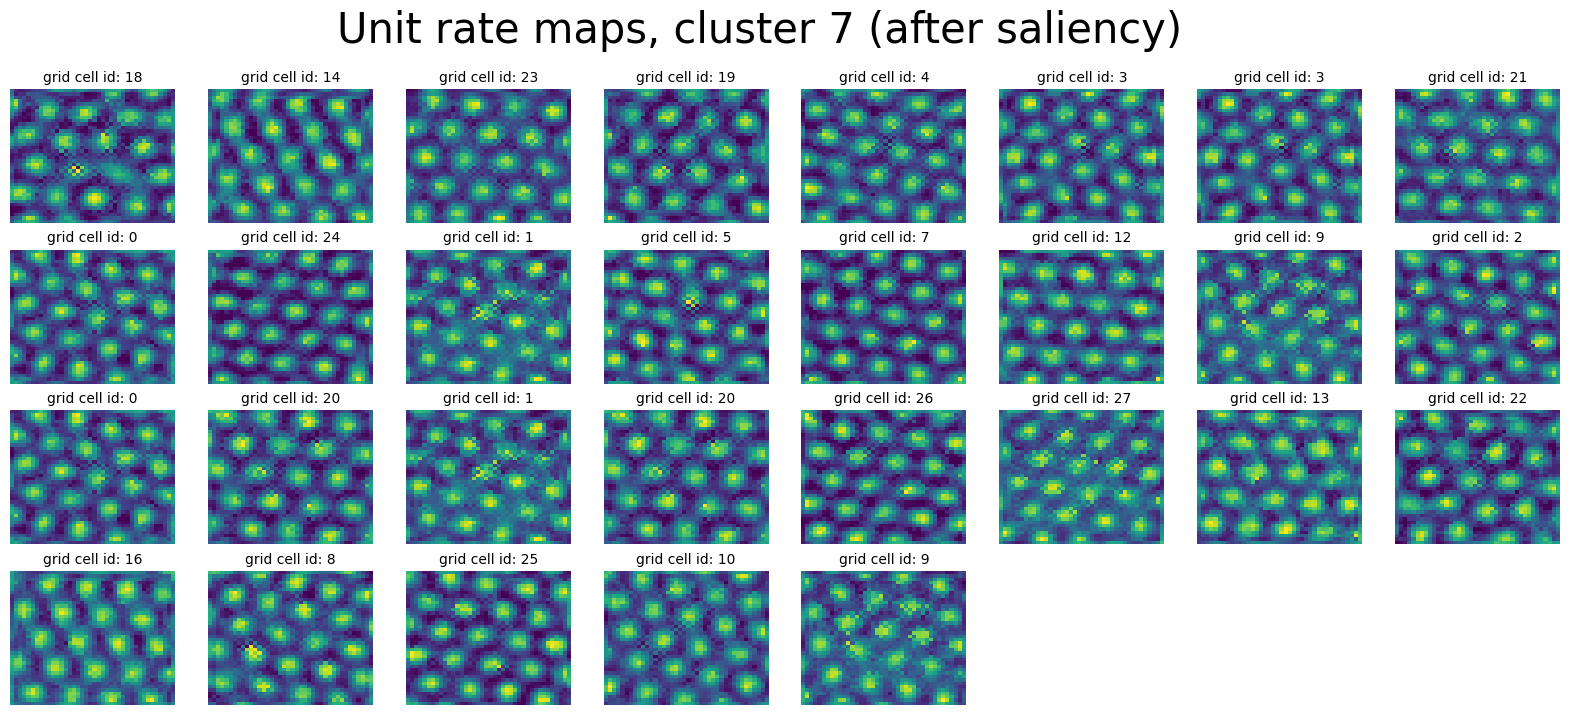

In [13]:
clusters_after = {}
for i in np.unique(umap_cluster_labels):
    cluster = activations_after["v"][umap_cluster_labels == i]
    clusters_after[i] = cluster

neural_points_after = (
    clusters_after[cluster_id].reshape(len(clusters_after[cluster_id]), -1).T
)
print(neural_points_after.shape)

plot_rate_map(
    None,
    min(40, num_cells_in_cluster),
    clusters_after[cluster_id],
    f"Unit rate maps, cluster {cluster_id} (after saliency)",
)

In [22]:
neural_points_after = {}
for cluster_id in clusters_after.keys():
    print(f"Cluster {cluster_id} has {clusters_after[cluster_id].shape[0]} units")
    neural_points_after[cluster_id] = (
        clusters_after[cluster_id].reshape(len(clusters_after[cluster_id]), -1).T
    )

Cluster -1 has 2 units
Cluster 0 has 1481 units
Cluster 1 has 187 units
Cluster 2 has 17 units
Cluster 3 has 19 units
Cluster 4 has 13 units
Cluster 5 has 11 units
Cluster 6 has 10 units
Cluster 7 has 29 units
Cluster 8 has 13 units
Cluster 9 has 18 units


In [29]:
activations_before["v"].shape

(1800, 40, 40)

In [30]:
activations_before["v"].reshape(-1, block_size, num_grid, num_grid).shape

(150, 12, 40, 40)

In [ ]:
draw_heatmap(
    activations_before["v"].reshape(-1, block_size, num_grid, num_grid)[:10, :10],
    title="Grid cell rate maps before",
);

In [56]:
neural_points_expt = {}
rate_maps_expt = {}
for id in np.unique(umap_cluster_labels):
    rate_maps_expt[id] = activations_after["v"][umap_cluster_labels == id]
    neural_points_expt[id] = rate_maps_expt[id].reshape(len(rate_maps_expt[id]), -1).T

neural_points_pretrained = {}
rate_maps_pretrained = {}
for id in np.unique(umap_cluster_labels):
    rate_maps_pretrained[id] = activations_before["v"][umap_cluster_labels == id]
    neural_points_pretrained[id] = (
        rate_maps_pretrained[id].reshape(len(rate_maps_pretrained[id]), -1).T
    )

In [57]:
rate_maps_pretrained[7].shape

(29, 40, 40)

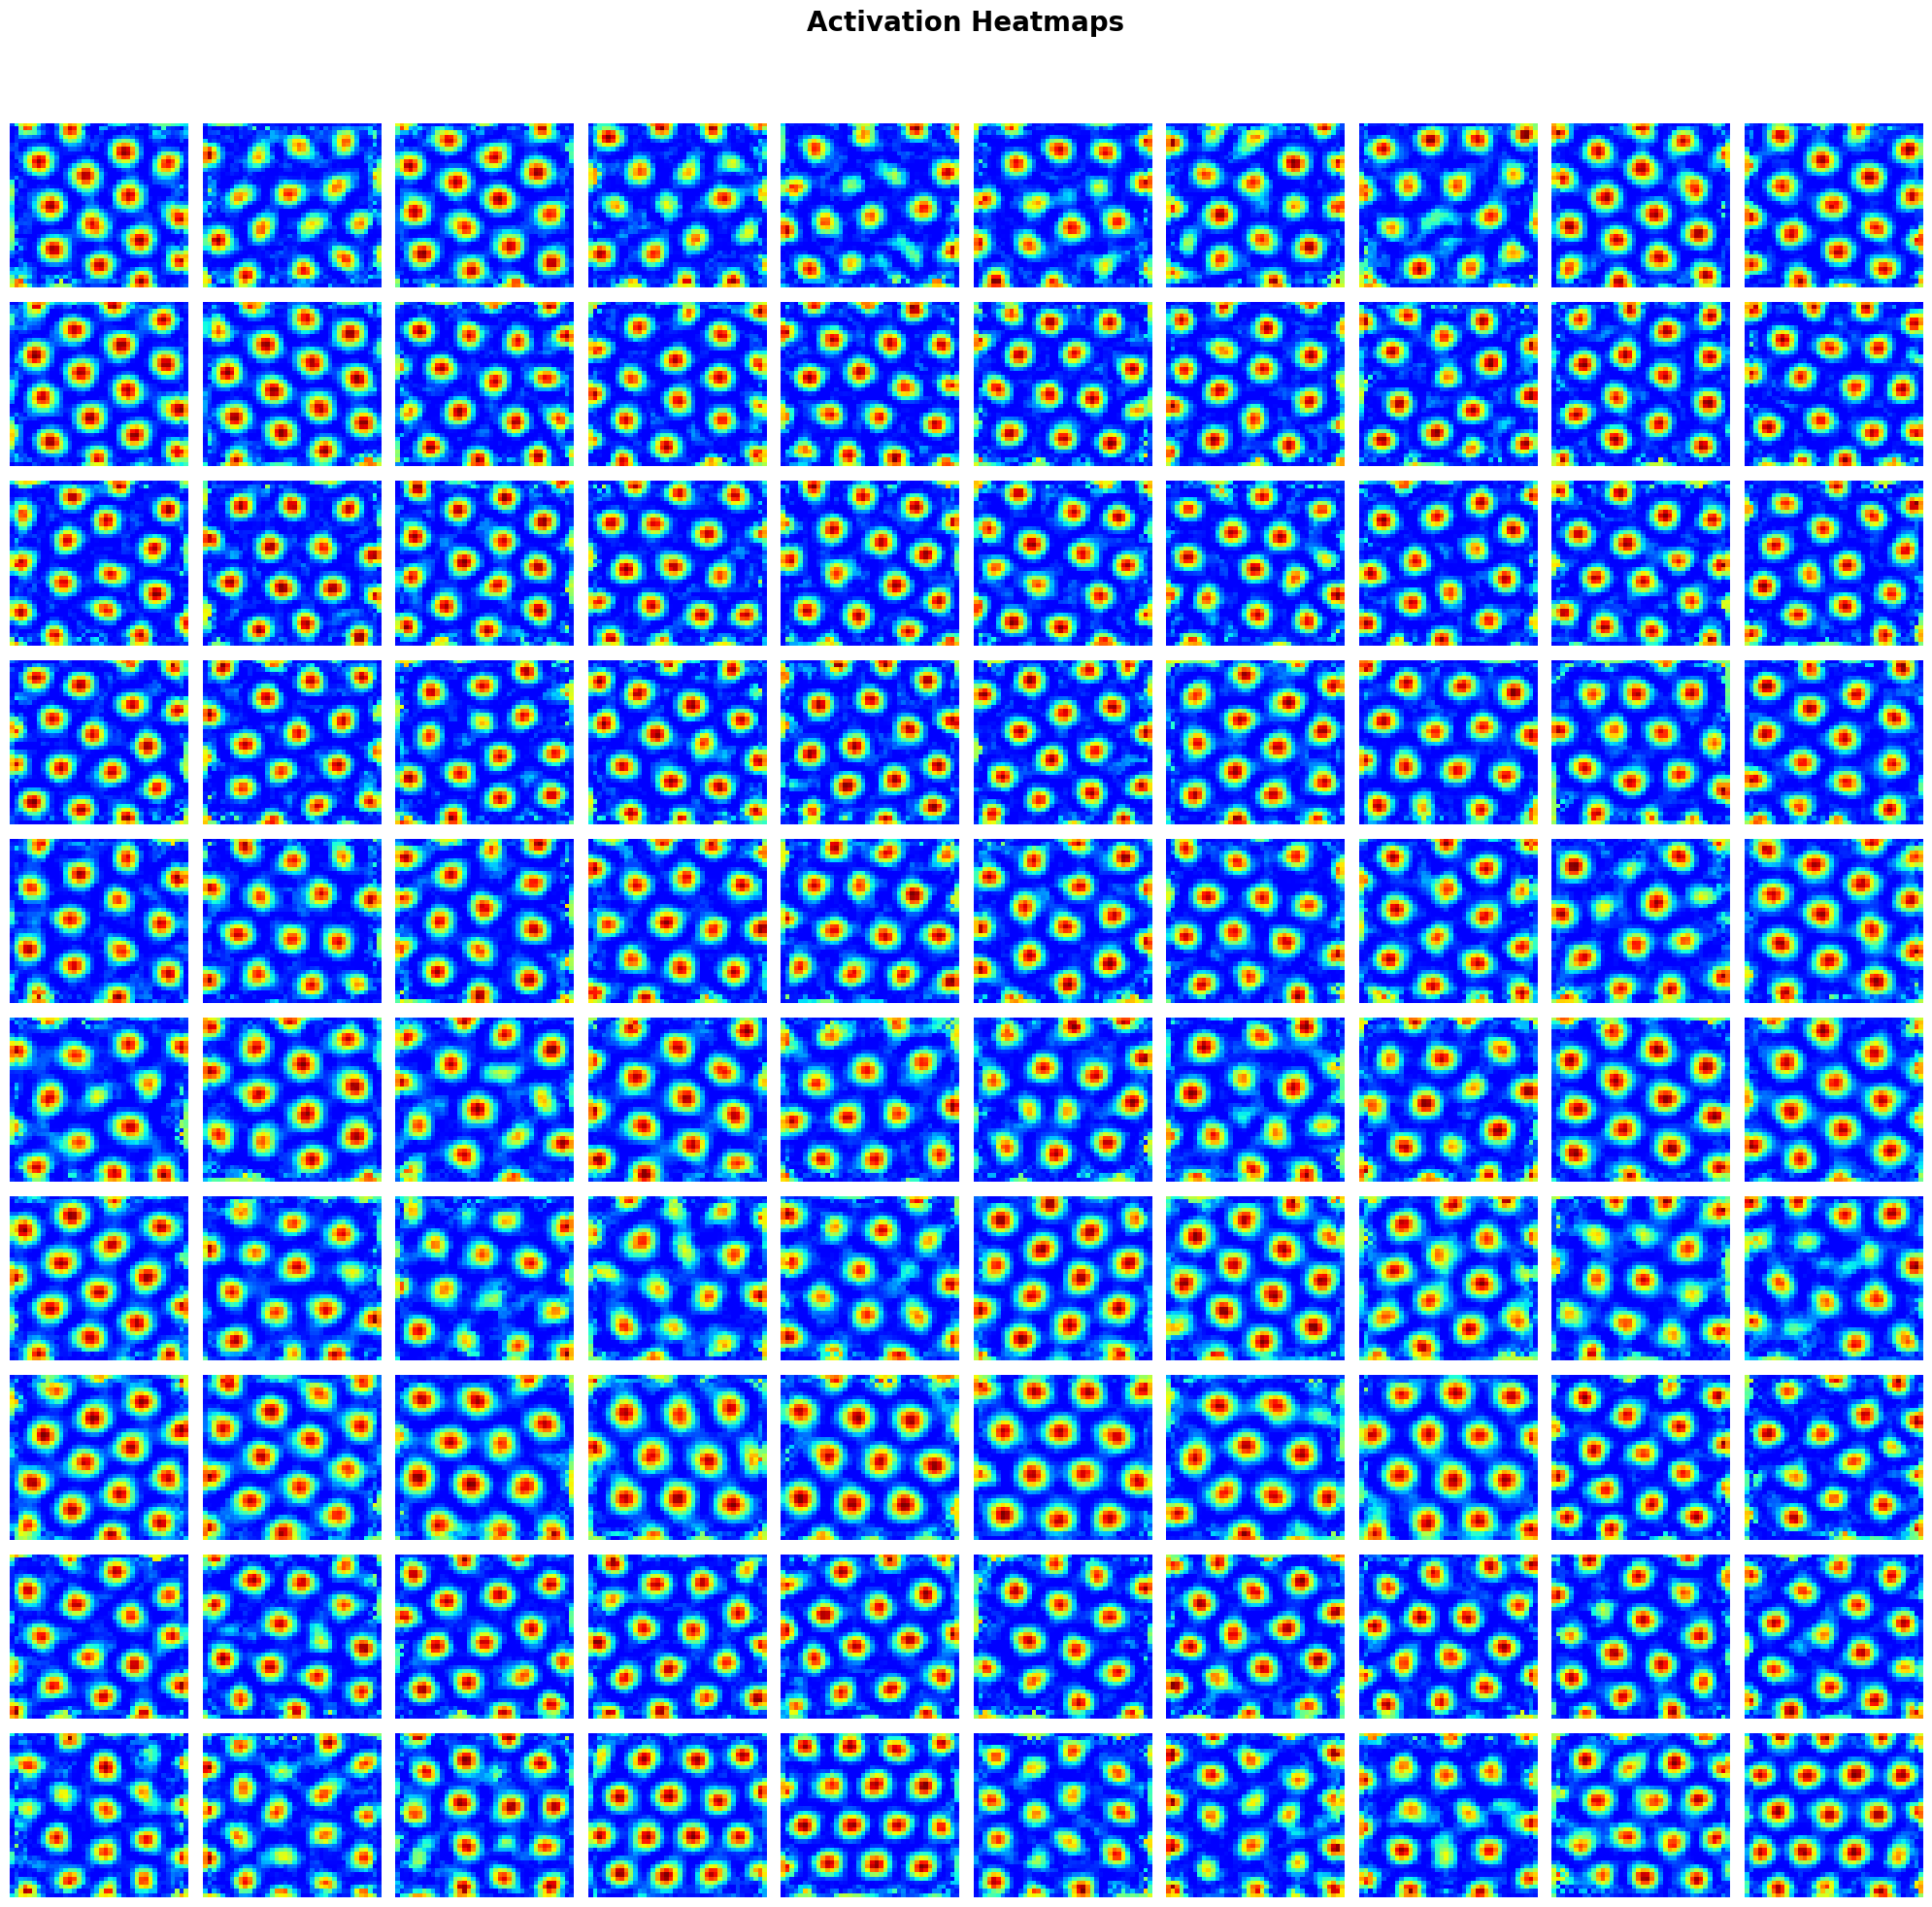

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm


def draw_heatmap(activations, title):
    # activations should be a 3-D tensor: [num_rate_maps, H, W]
    num_rate_maps = min(activations.shape[0], 100)
    H, W = activations.shape[1], activations.shape[2]

    # Determine the number of rows and columns for the plot grid
    ncol = int(np.ceil(np.sqrt(num_rate_maps)))
    nrow = int(np.ceil(num_rate_maps / ncol))

    fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 2, nrow * 2))
    fig.suptitle(title, fontsize=20, fontweight="bold", verticalalignment="top")

    for i in range(num_rate_maps):
        row, col = divmod(i, ncol)
        if nrow == 1:
            ax = axs[col]
        elif ncol == 1:
            ax = axs[row]
        else:
            ax = axs[row, col]

        weight = activations[i]
        vmin, vmax = weight.min() - 0.01, weight.max()

        cmap = cm.get_cmap("jet", 1000)
        cmap.set_under("w")

        ax.imshow(
            weight,
            interpolation="nearest",
            cmap=cmap,
            aspect="auto",
            vmin=vmin,
            vmax=vmax,
        )
        ax.axis("off")

    # Hide any remaining empty subplots
    if num_rate_maps < nrow * ncol:
        for j in range(num_rate_maps, nrow * ncol):
            row, col = divmod(j, ncol)
            if nrow == 1:
                ax = axs[col]
            elif ncol == 1:
                ax = axs[row]
            else:
                fig.delaxes(axs[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig
    # plt.show()
    # plt.close(fig)

    # # Create image from plot for potential further use
    # fig.canvas.draw()
    # image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    # image_from_plot = image_from_plot.reshape(
    #     fig.canvas.get_width_height()[::-1] + (3,)
    # )


# np.expand_dims(image_from_plot, axis=0)


obj = draw_heatmap(rate_maps_pretrained[1], title="Activation Heatmaps");

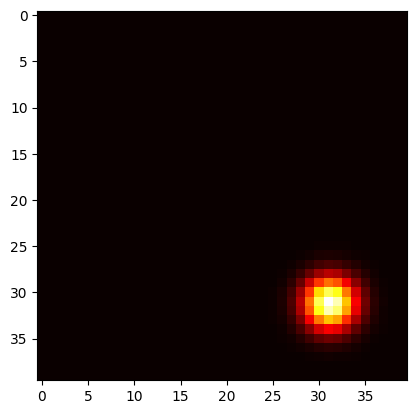

In [79]:
# given an intensity, a location, and a scale, generate a 2D gaussian on a 40x40 grid. Don't use scipy


def generate_gaussian(intensity, location=0.8, scale=0.1):
    x = np.arange(40)
    y = np.arange(40)
    X, Y = np.meshgrid(x, y)
    location = 40 * location
    scale = 40 * scale
    Z = np.exp(-((X - location) ** 2 + (Y - location) ** 2) / (2 * scale**2))
    kernel = 1 + intensity * Z
    fig, ax = plt.subplots()
    ax.imshow(kernel, cmap="hot")
    return fig


# change above function to make x and y ticks from 0 to 1


def generate_gaussian(intensity, location=0.8, scale=0.1):
    x = np.linspace(0, 1, 40)
    y = np.linspace(0, 1, 40)
    X, Y = np.meshgrid(x, y)
    location = location
    scale = scale
    Z = np.exp(-((X - location) ** 2 + (Y - location) ** 2) / (2 * scale**2))
    kernel = 1 + intensity * Z
    fig, ax = plt.subplots()
    ax.imshow(kernel, cmap="hot")
    return fig


gaussian = generate_gaussian(1, 0.8, 0.05)

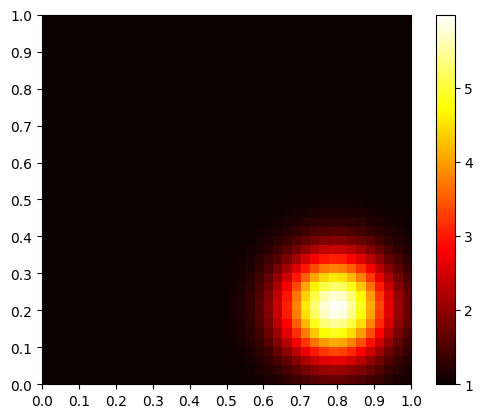

In [77]:
def plot_gaussian_kernel(intensity, location=0.8, scale=0.1):
    x = np.linspace(0, 1, 40)
    y = np.linspace(0, 1, 40)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(-((X - location) ** 2 + (Y - location) ** 2) / (2 * scale**2))
    kernel = 1 + intensity * Z

    fig, ax = plt.subplots()
    cax = ax.imshow(kernel, cmap="hot", extent=[0, 1, 0, 1])

    ax.set_xticks(np.linspace(0, 1, num=11))  # Set x-ticks from 0 to 1
    ax.set_yticks(np.linspace(0, 1, num=11))  # Set y-ticks from 0 to 1
    ax.set_xticklabels(np.round(np.linspace(0, 1, num=11), 2))
    ax.set_yticklabels(np.round(np.linspace(0, 1, num=11), 2))

    plt.colorbar(cax, ax=ax, orientation="vertical")
    return fig

In [59]:
def _saliency_kernel_gaussian(self, x_grid):
    s_0 = 10
    x_saliency = np.array([0.8, 0.8])
    sigma_saliency = 0.1

    # Calculate the squared differences, scaled by respective sigma values
    diff = x_grid - x_saliency
    scaled_diff_sq = (diff[:, 0]**2 / sigma_saliency**2) + (diff[:, 1]**2 / sigma_saliency**2)

    # Compute the Gaussian function
    normalization_factor = 2 * np.pi * sigma_saliency * sigma_saliency
    s_x = s_0 * torch.exp(-0.5 * scaled_diff_sq) / normalization_factor

    return 1 + s_x

(187, 40, 40)

### Or: define subpopulation using predefined "blocks"

(1600, 150)


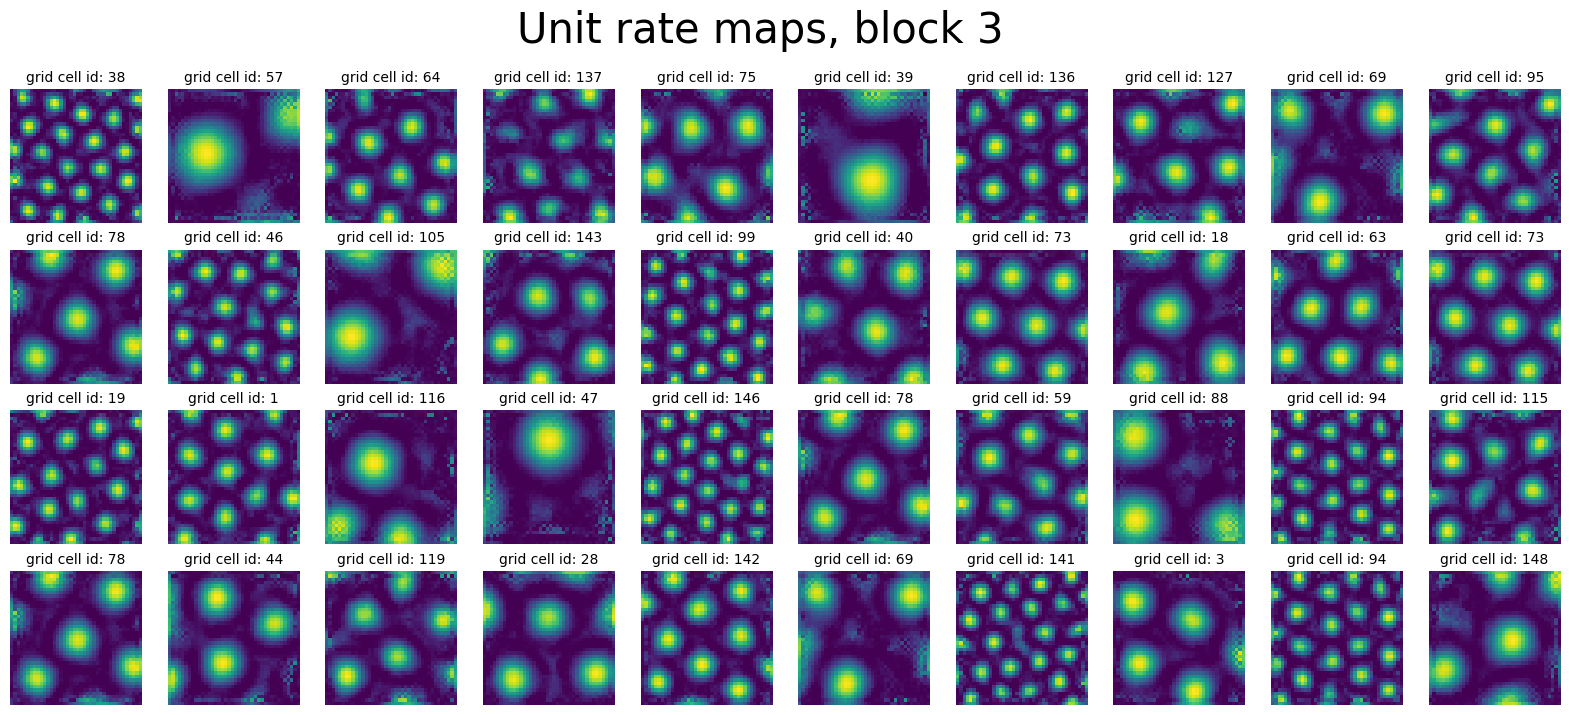

In [60]:
block_id = 3


activations_block = activations_before["v"].reshape(-1, block_size, num_grid, num_grid)[
    :, block_id, :, :
]

block_neural_points = activations_block.reshape(-1, num_grid * num_grid).T

print(block_neural_points.shape)

plot_rate_map(
    None,
    min(40, 150),
    activations_block,
    f"Unit rate maps, block {block_id}",
)

## Manifold Visualizations

### Synthetic 3D torus

In [61]:
# from neurometry.datasets.synthetic import hypertorus
# TODO: implement parameterization="canonical_3d"
# torus_points = hypertorus(2, 500, parameterization="canonical_3d")

In [62]:
from neurometry.curvature.datasets.synthetic import (
    load_t2_synthetic,
)

num_points = 1600

torus_3d, _ = load_t2_synthetic(
    "random",
    n_times=num_points,
    major_radius=2,
    minor_radius=1,
    geodesic_distortion_amp=0,
    embedding_dim=3,
    noise_var=0.0001,
)

torus_3d = np.array(torus_3d)

torus_3d_warped, _ = load_t2_synthetic(
    "random",
    n_times=num_points,
    major_radius=2,
    minor_radius=1,
    geodesic_distortion_amp=0.5,
    embedding_dim=3,
    noise_var=0.0001,
)

torus_3d_warped = np.array(torus_3d_warped)

# plot torus_3d and torus_3d_warped side by side using plotly

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]],
)

fig.add_trace(
    go.Scatter3d(
        x=torus_3d[:, 0],
        y=torus_3d[:, 1],
        z=torus_3d[:, 2],
        mode="markers",
        marker=dict(size=4),
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter3d(
        x=torus_3d_warped[:, 0],
        y=torus_3d_warped[:, 1],
        z=torus_3d_warped[:, 2],
        mode="markers",
        marker=dict(size=4),
    ),
    row=1,
    col=2,
)

fig.update_layout(height=600, width=1200, title_text="Torus 3D and Warped Torus 3D")

fig.show()

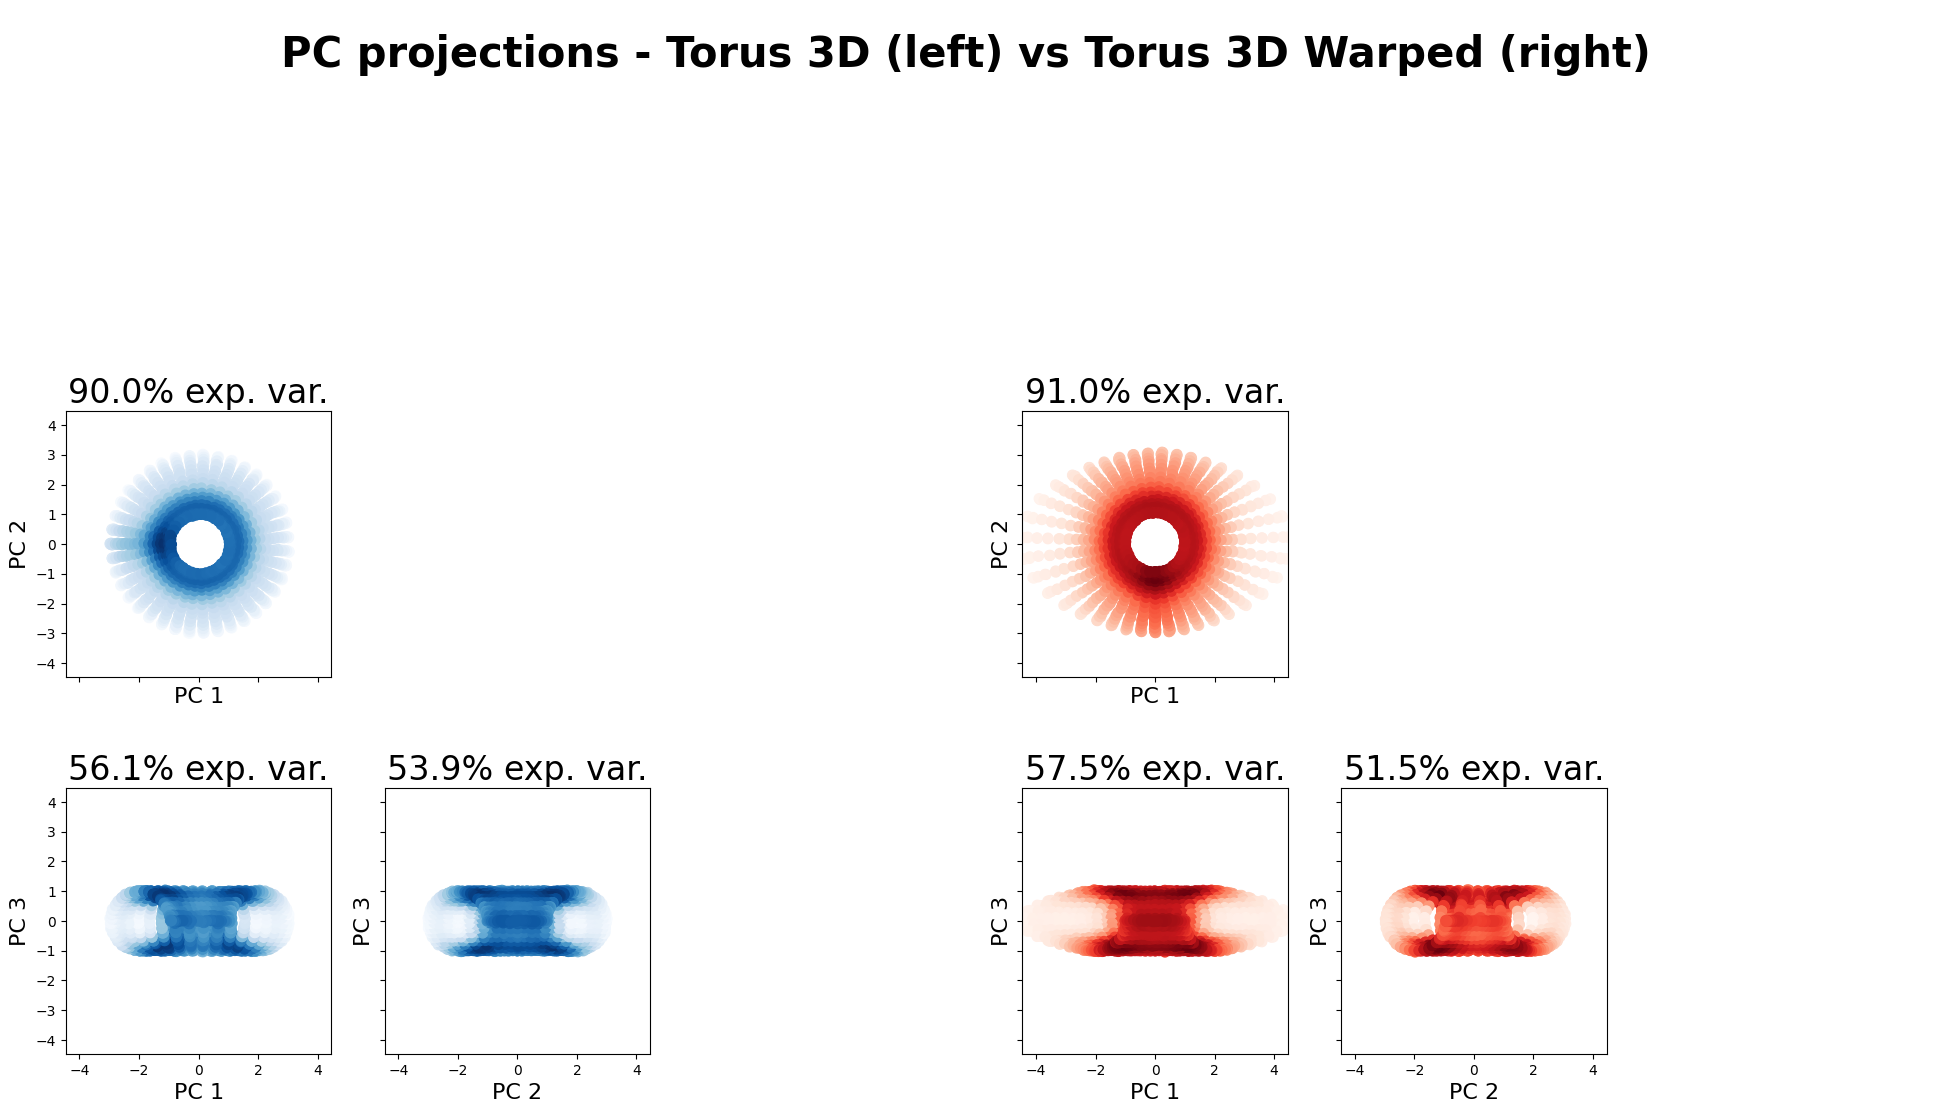

The 3 top PCs in Torus 3D explain 100.00% of the variance
The 3 top PCs in Torus 3D Warped explain 100.00% of the variance


In [63]:
from neurometry.dimension.dim_reduction import plot_pca_projections

plot_pca_projections(torus_3d, torus_3d_warped, "Torus 3D", "Torus 3D Warped", K=3);

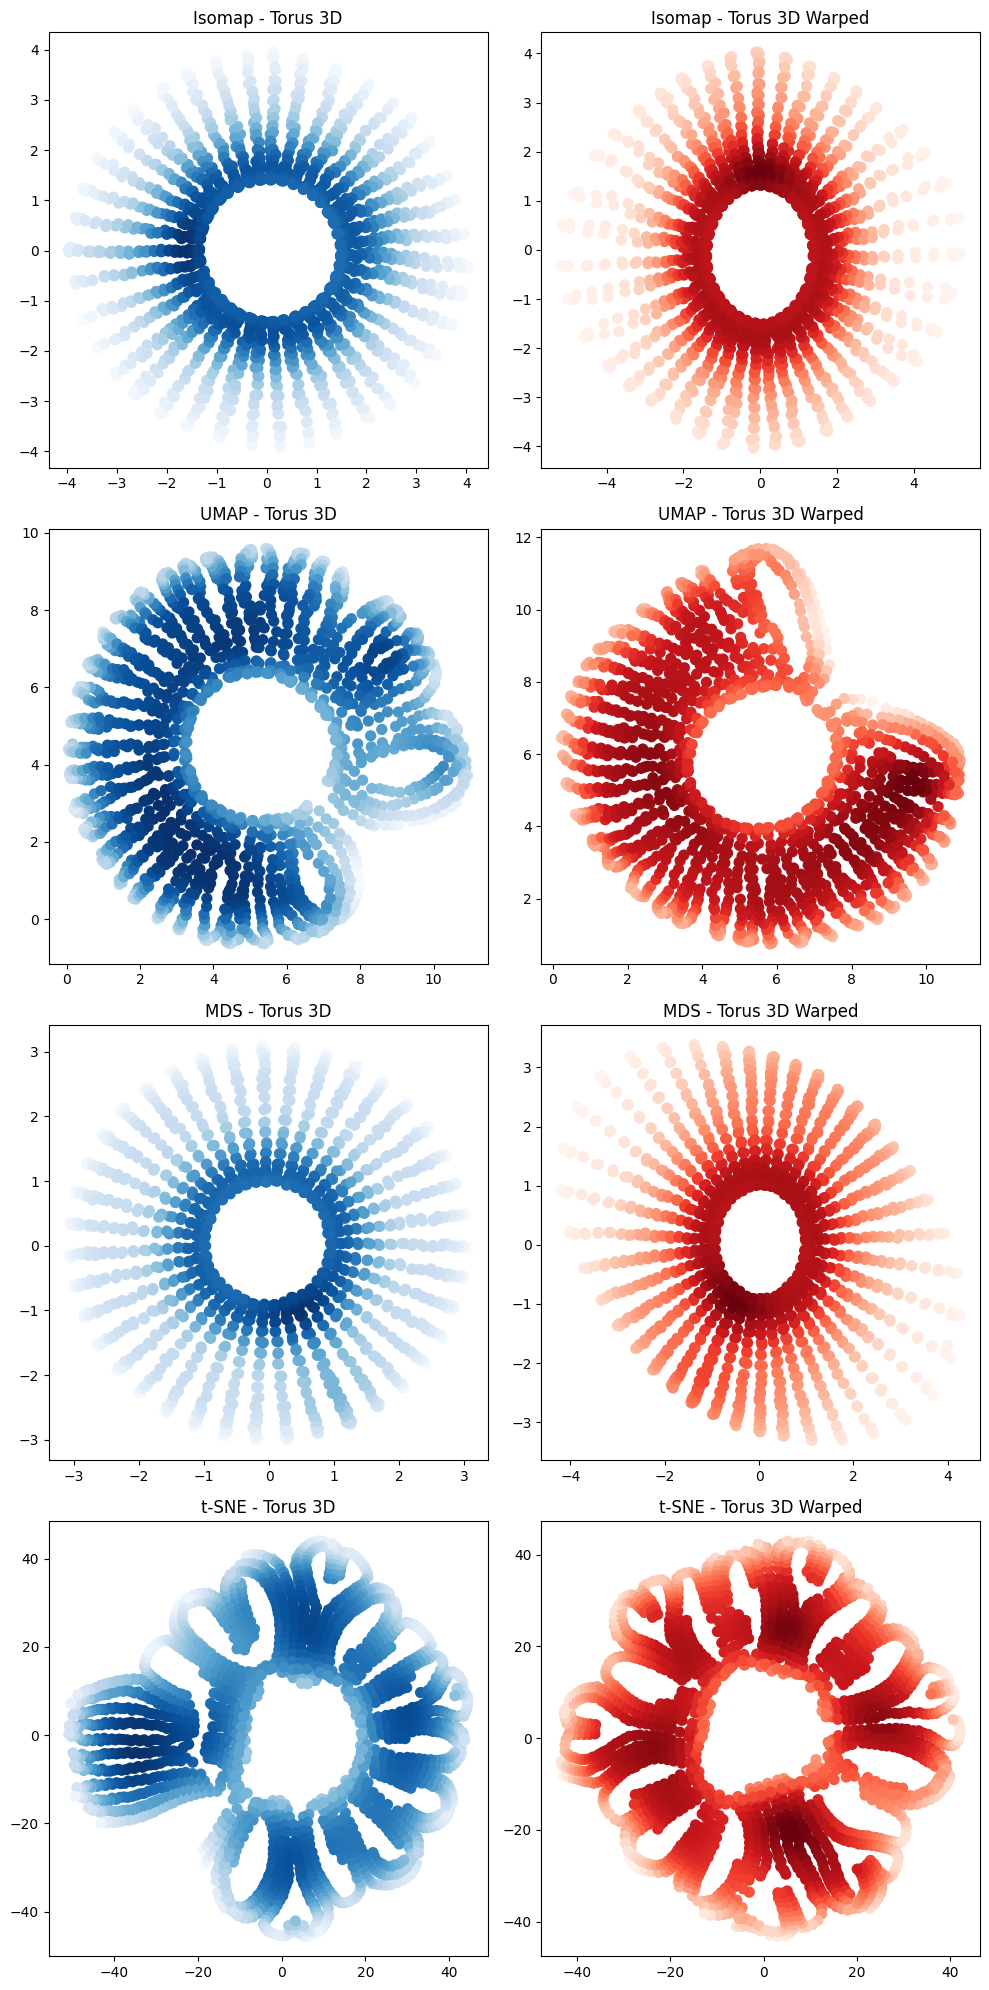

In [64]:
from neurometry.dimension.dim_reduction import plot_2d_manifold_projections

projections_fig = plot_2d_manifold_projections(
    torus_3d, torus_3d_warped, "Torus 3D", "Torus 3D Warped"
)

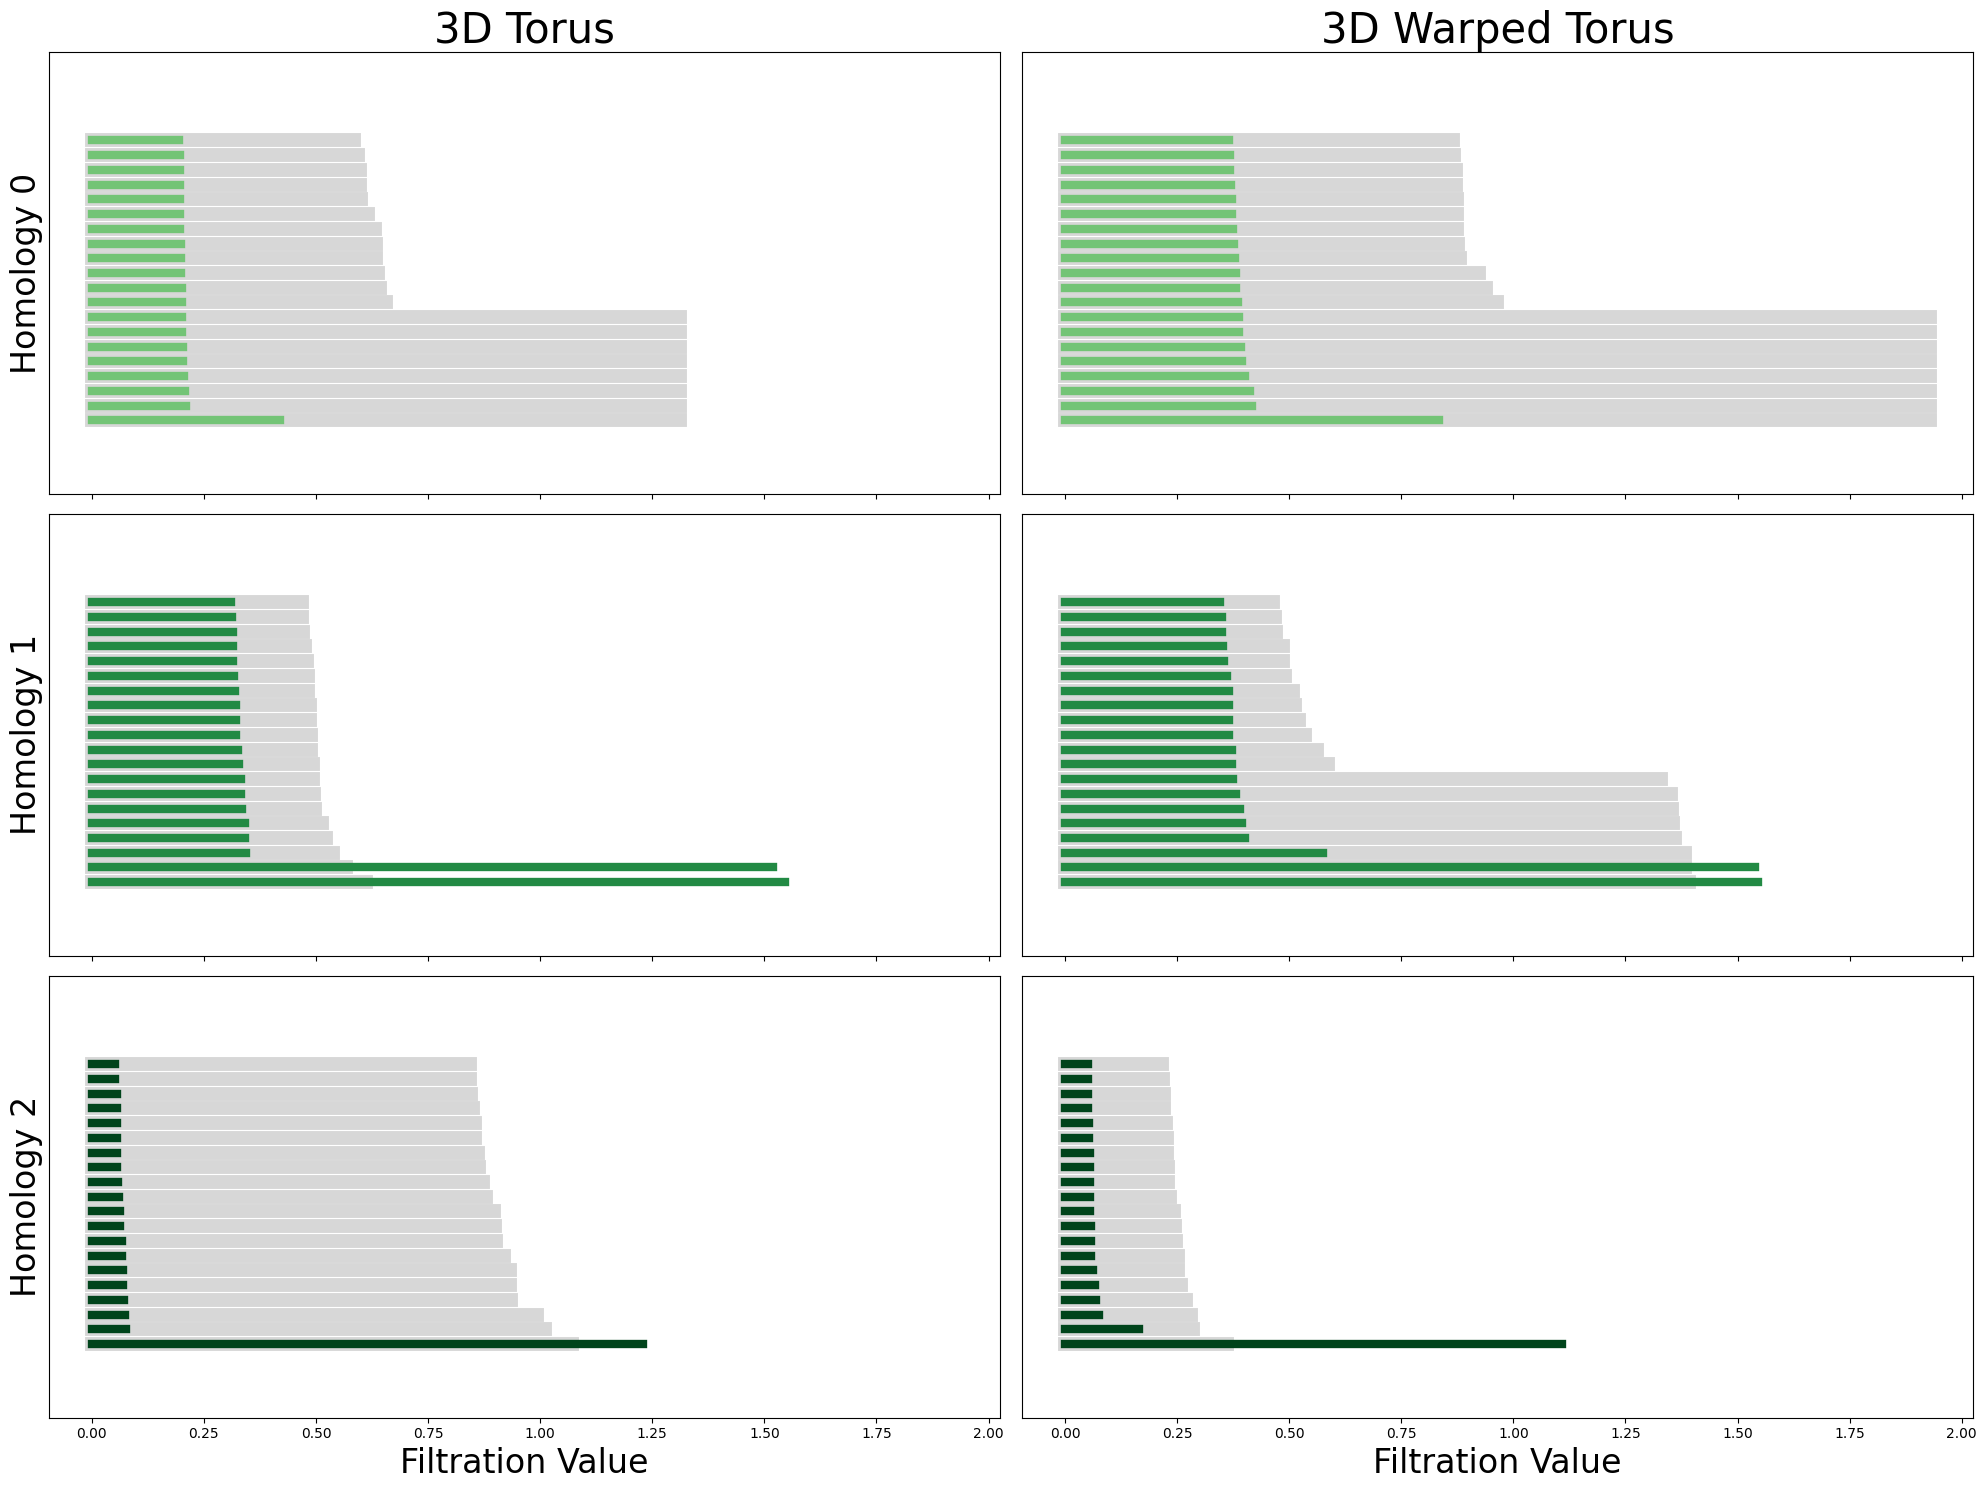

In [65]:
from neurometry.topology.persistent_homology import compute_diagrams_shuffle

torus_3d_diagrams = compute_diagrams_shuffle(
    torus_3d, num_shuffles=8, homology_dimensions=(0, 1, 2)
)
torus_3d_warped_diagrams = compute_diagrams_shuffle(
    torus_3d_warped, num_shuffles=8, homology_dimensions=(0, 1, 2)
)

from neurometry.topology.plotting import plot_all_barcodes_with_null

plot_all_barcodes_with_null(
    torus_3d_diagrams, torus_3d_warped_diagrams, "3D Torus", "3D Warped Torus"
);

### RNN module torus

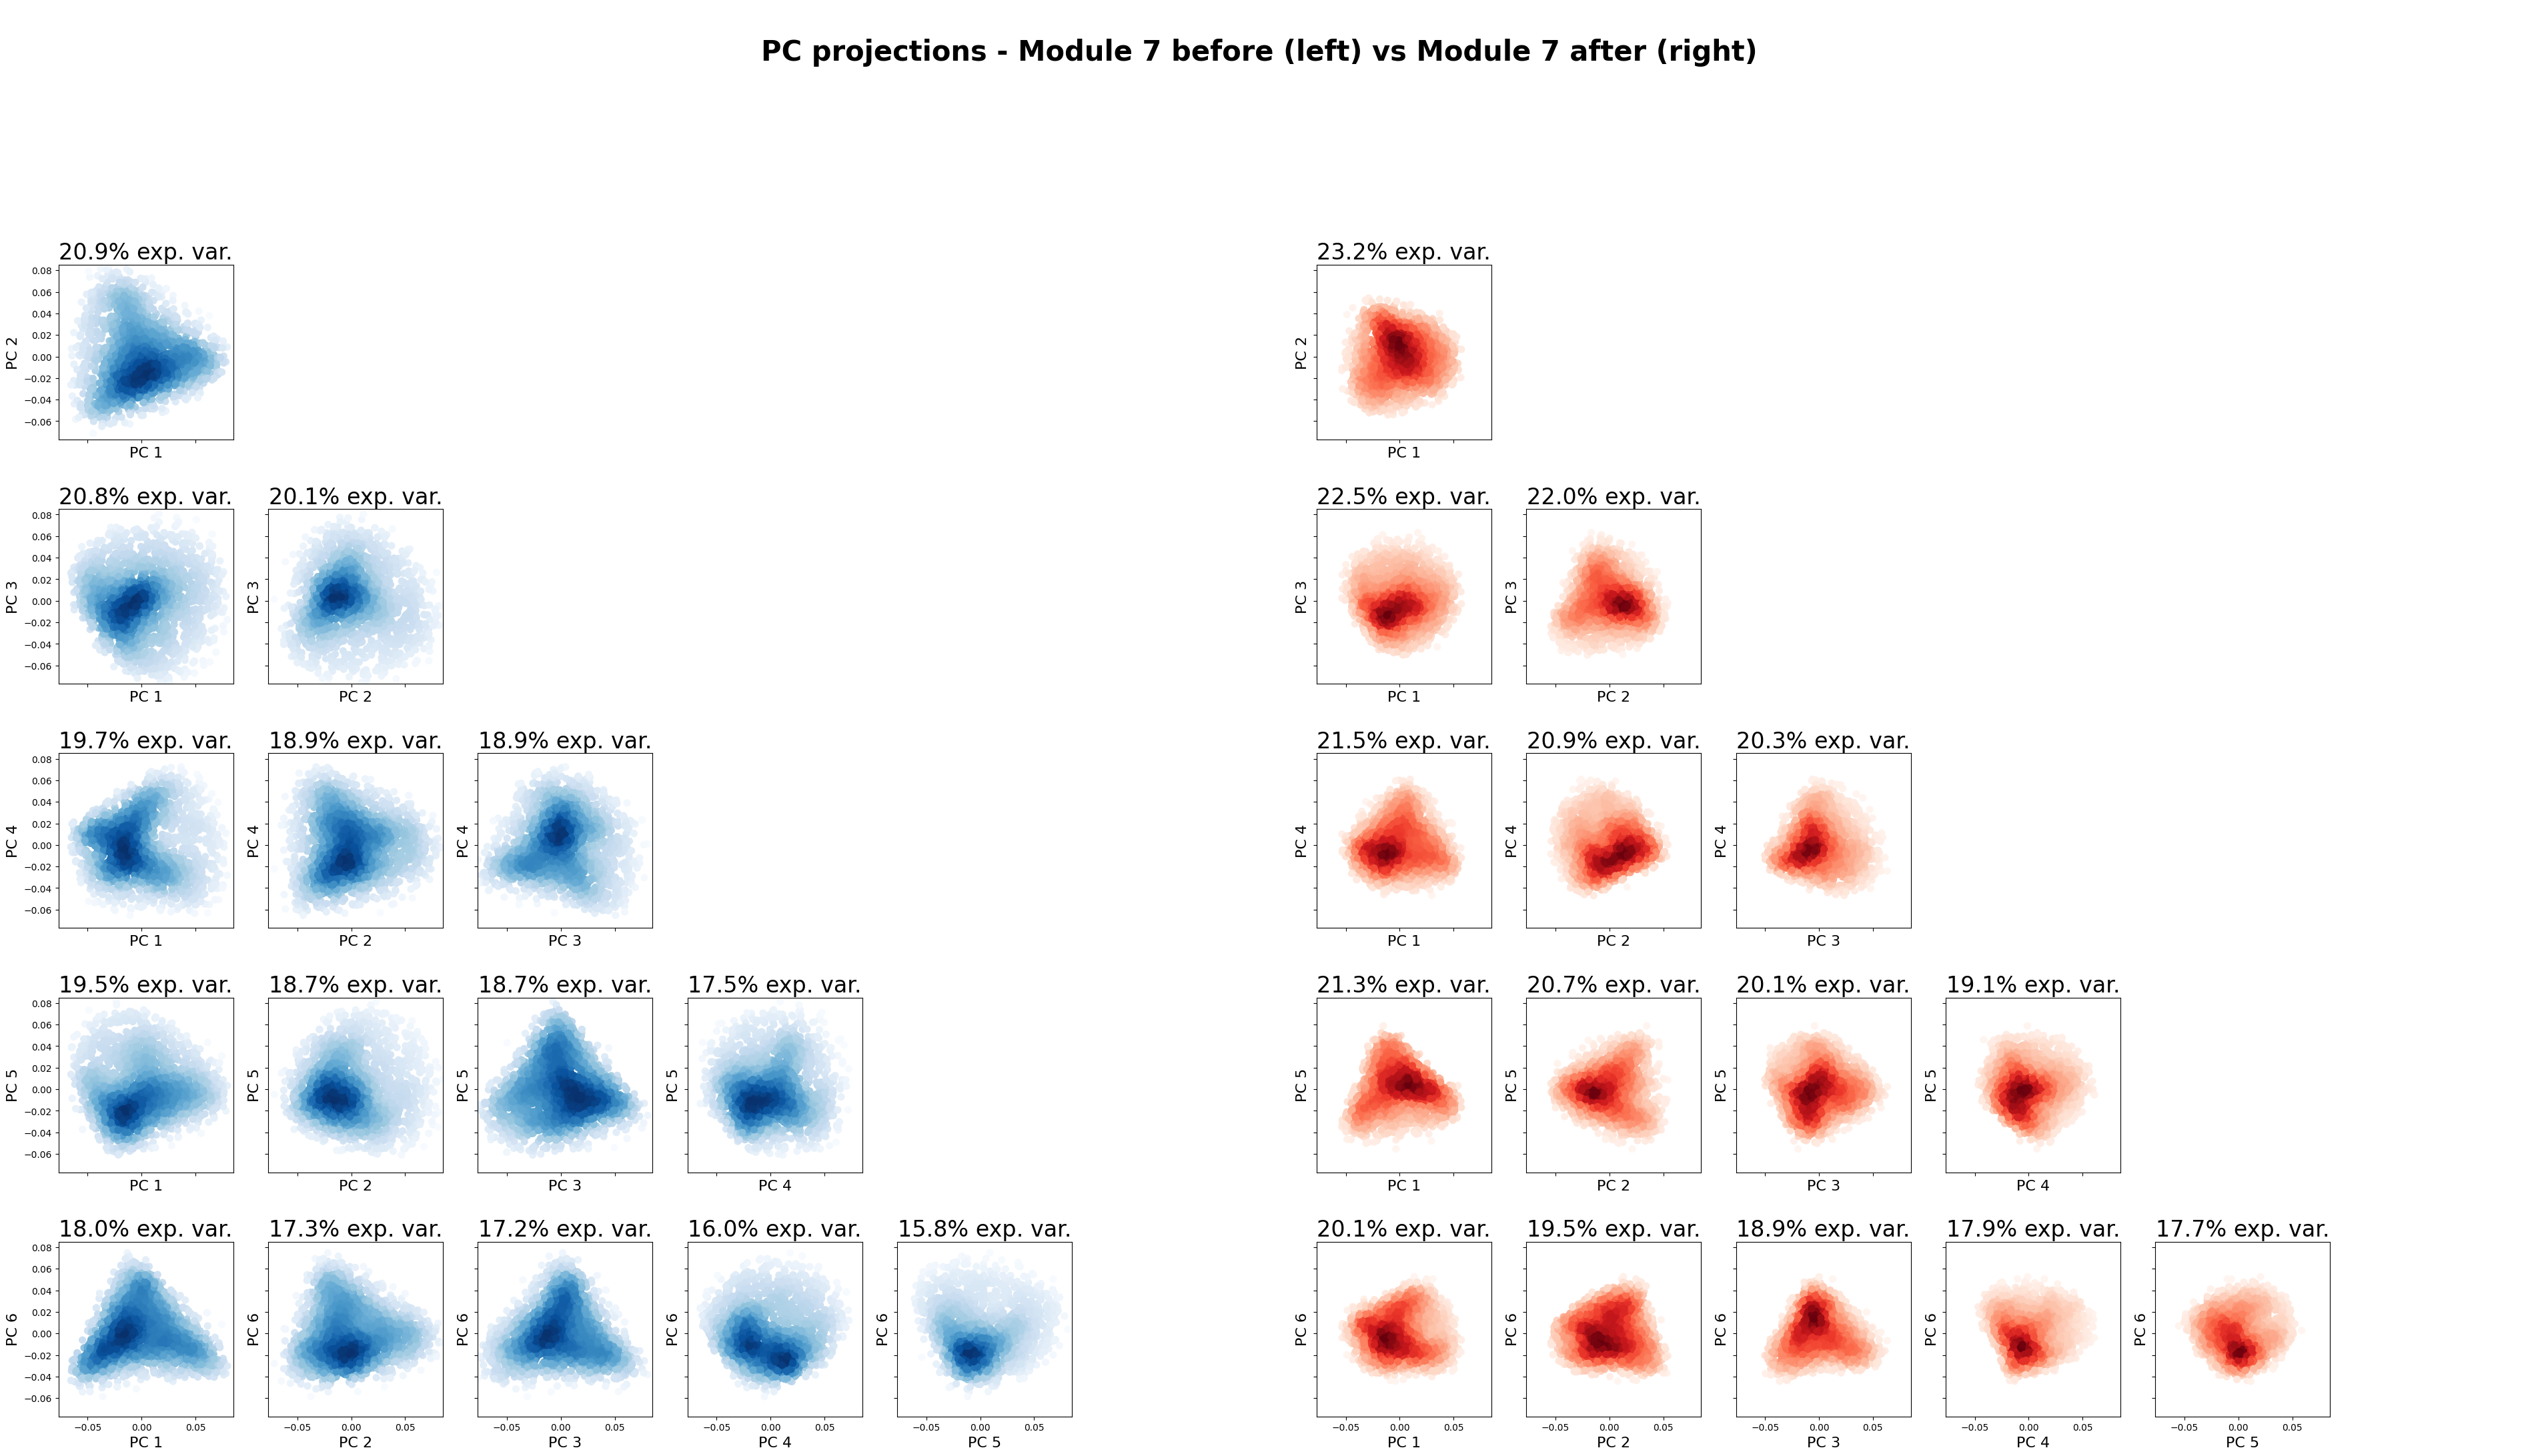

The 6 top PCs in Module 7 before explain 55.59% of the variance
The 6 top PCs in Module 7 after explain 61.11% of the variance


In [66]:
from neurometry.dimension.dim_reduction import plot_pca_projections

plot_pca_projections(
    neural_points_before,
    neural_points_after,
    f"Module {cluster_id} before",
    f"Module {cluster_id} after",
    K=6,
);

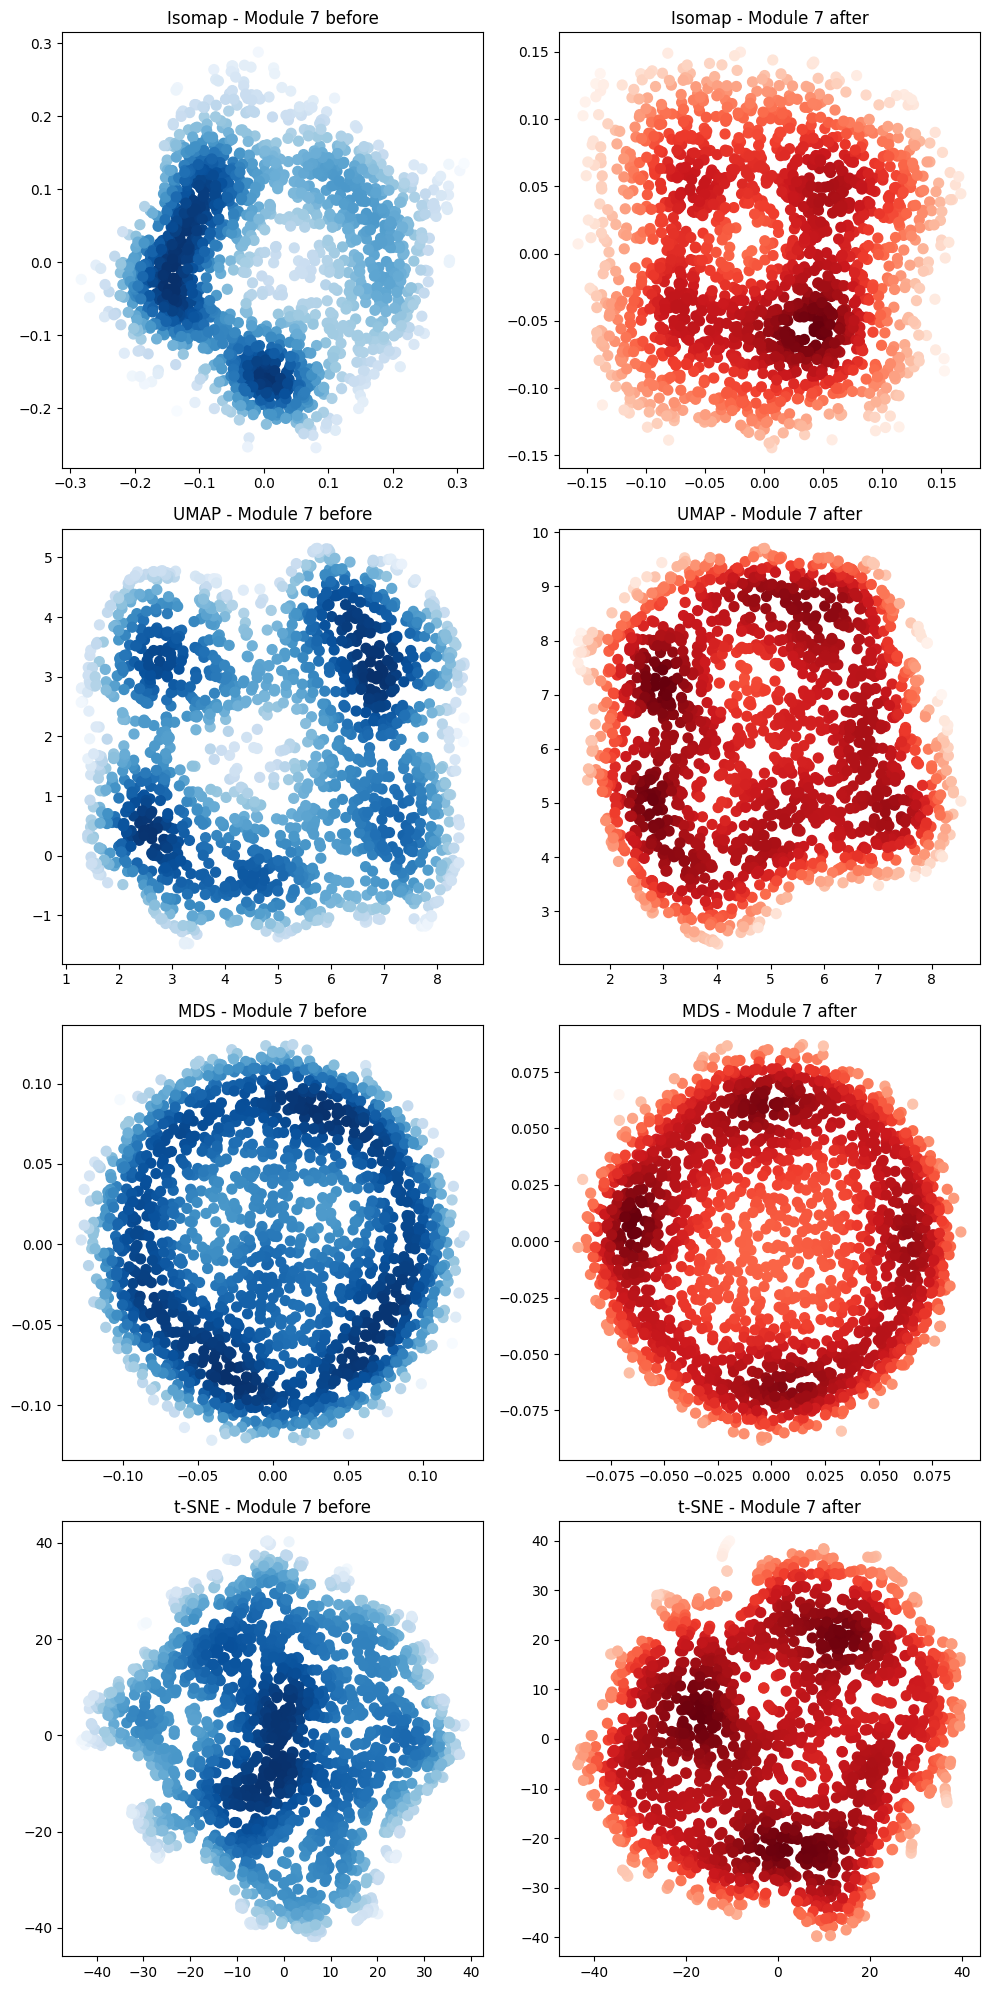

In [67]:
projections_fig = plot_2d_manifold_projections(
    neural_points_before,
    neural_points_after,
    f"Module {cluster_id} before",
    f"Module {cluster_id} after",
)

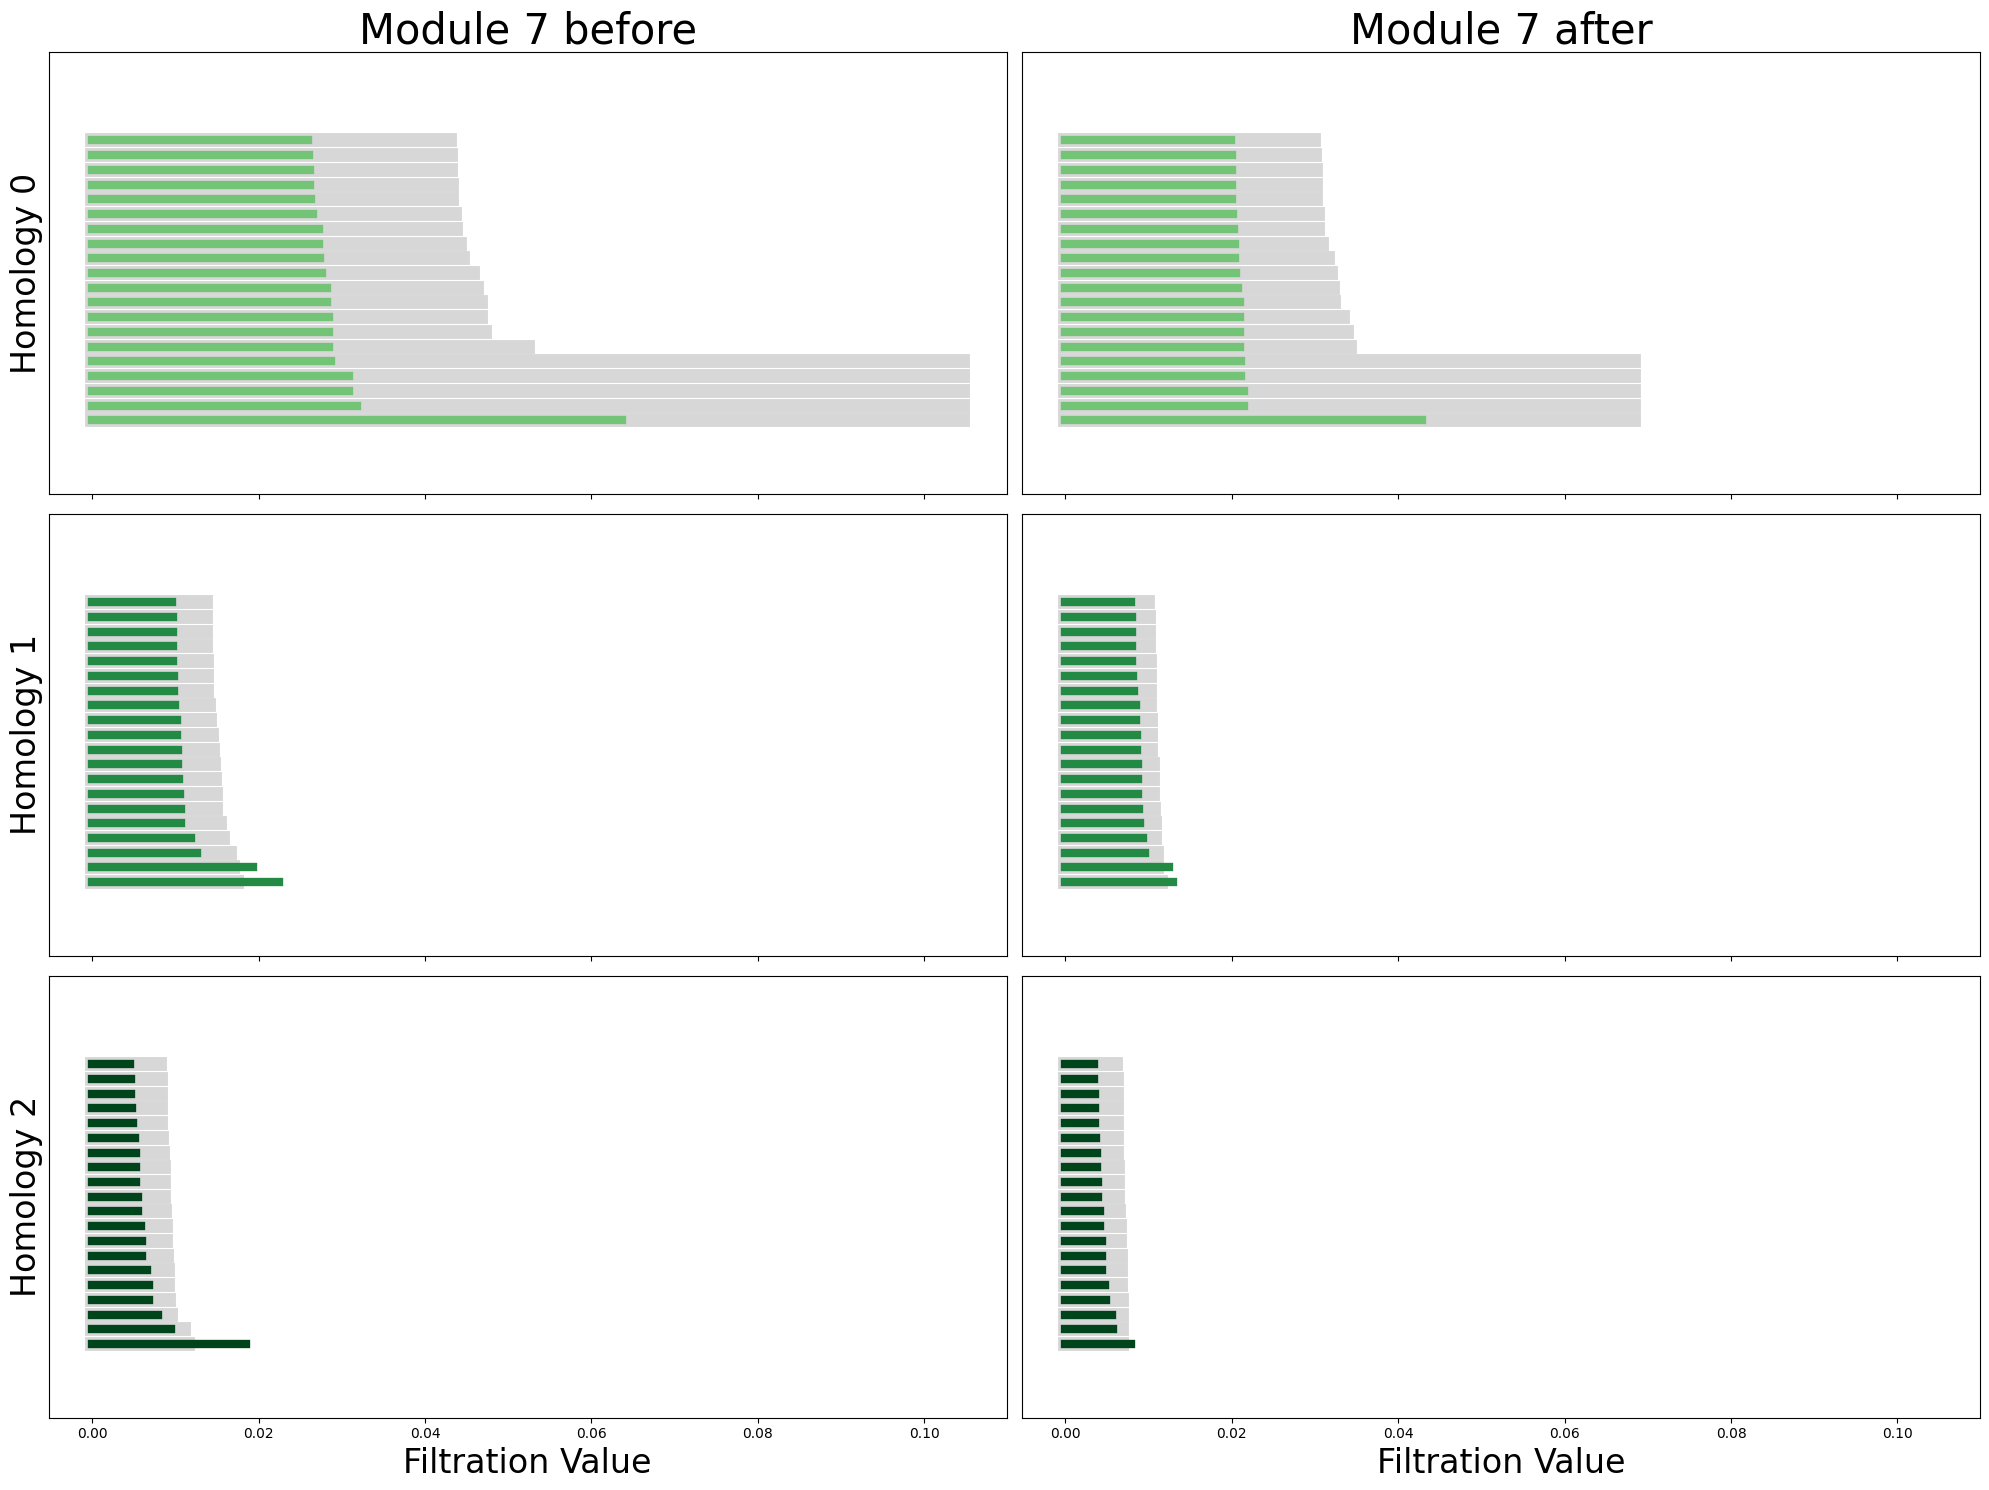

In [68]:
from sklearn.decomposition import PCA

pca_before = PCA(n_components=6)
neural_points_before_pca = pca_before.fit_transform(neural_points_before)
module_before_diagrams = compute_diagrams_shuffle(
    neural_points_before_pca, num_shuffles=5, homology_dimensions=(0, 1, 2)
)
pca_after = PCA(n_components=6)
neural_points_after_pca = pca_after.fit_transform(neural_points_after)
module_after_diagrams = compute_diagrams_shuffle(
    neural_points_after_pca, num_shuffles=5, homology_dimensions=(0, 1, 2)
)

plot_all_barcodes_with_null(
    module_before_diagrams,
    module_after_diagrams,
    f"Module {cluster_id} before",
    f"Module {cluster_id} after",
);

### RNN module torus cohomological coordinates

In [69]:
from neurometry.topology.persistent_homology import cohomological_toroidal_coordinates

from neurometry.topology.plotting import plot_activity_on_torus

toroidal_coords = cohomological_toroidal_coordinates(neural_points_before_pca)
fig = plot_activity_on_torus(neural_points_before, toroidal_coords, neuron_id=13)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False);

In [87]:
toroidal_coords_after = cohomological_toroidal_coordinates(neural_points_after_pca)
fig = plot_activity_on_torus(neural_points_after, toroidal_coords_after, neuron_id=13)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False);

## Dimensionality Estimation

(1600, 2)


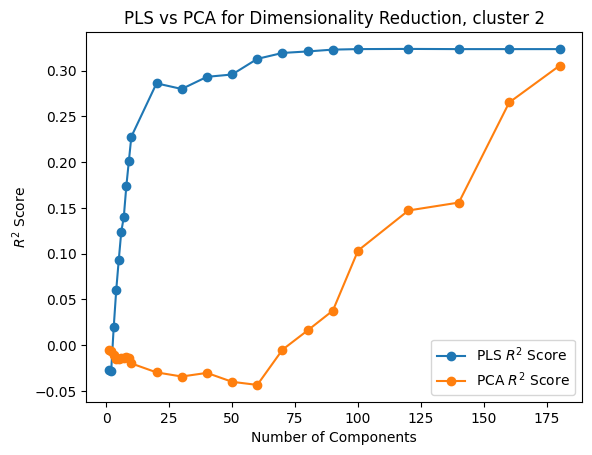

In [139]:
box_width = 1
res = 40

bin_edges = np.linspace(0, box_width, res + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

x_centers, y_centers = np.meshgrid(bin_centers, bin_centers[::-1])

positions_array = np.stack([x_centers, y_centers], axis=-1)

# Flatten the coordinate array to shape (400, 2)
positions = positions_array.reshape(-1, 2)


print(positions.shape)


X = neural_points
Y = positions

from neurometry.dimension.dimension import (
    evaluate_PCA_with_different_K,
    evaluate_pls_with_different_K,
)

K_values = [*range(1,10),*range(10,100,10),*range(100,200,20)]
# K_values = [*range(1,10),*range(10,30,5)]

pca_r2_scores, pca_transformed_X = evaluate_PCA_with_different_K(X, Y, K_values)

pls_r2_scores, pls_transformed_X = evaluate_pls_with_different_K(X, Y, K_values)

plt.plot(K_values, pls_r2_scores, marker="o", label="PLS $R^2$ Score")

plt.plot(K_values, pca_r2_scores, marker="o", label="PCA $R^2$ Score")

plt.xlabel("Number of Components")

plt.ylabel("$R^2$ Score")

plt.title(f"PLS vs PCA for Dimensionality Reduction, cluster {cluster_id}")

plt.legend();

## Curvature computation

In [17]:
from neurometry.topology.persistent_homology import cohomological_toroidal_coordinates


toroidal_coords_torus_3d = cohomological_toroidal_coordinates(torus_3d)

toroidal_coords_torus_3d_warped = cohomological_toroidal_coordinates(torus_3d_warped)

In [87]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from neurometry.curvature.torus_embedding import TorusDataset

toroidal_coords = toroidal_coords_torus_3d_warped
neural_vectors = torus_3d_warped

(
    toroidal_coords_train,
    toroidal_coords_test,
    neural_vectors_train,
    neural_vectors_test,
) = train_test_split(toroidal_coords, neural_vectors, test_size=0.2, random_state=42)

# Create Datasets
train_dataset = TorusDataset(toroidal_coords_train, neural_vectors_train)
test_dataset = TorusDataset(toroidal_coords_test, neural_vectors_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [88]:
from neurometry.curvature.torus_embedding import NeuralEmbedding, Trainer

# network parameters
input_dim = toroidal_coords.shape[1]
output_dim = neural_vectors.shape[1]
num_hidden = 4
hidden_dims = 64
sft_beta = 4.5

model = NeuralEmbedding(input_dim, output_dim, hidden_dims, num_hidden, sft_beta)

# train parameters
criterion = torch.nn.MSELoss()
learning_rate = 0.001
scheduler = False
num_epochs = 100

trainer = Trainer(model, train_loader, test_loader, criterion, learning_rate, scheduler)


trainer.train(num_epochs)

Epoch 1/100, Train Loss: 1.580706899931904, Test Loss: 1.2768140615000836
Epoch 2/100, Train Loss: 1.0192886103875591, Test Loss: 0.6691751543048807
Epoch 3/100, Train Loss: 0.5871922359970261, Test Loss: 0.4797587602832715
Epoch 4/100, Train Loss: 0.4285421607973966, Test Loss: 0.3742425004386295
Epoch 5/100, Train Loss: 0.2740521010917906, Test Loss: 0.2171828975161792
Epoch 6/100, Train Loss: 0.16206806381031358, Test Loss: 0.1396455730894542
Epoch 7/100, Train Loss: 0.11028543443361752, Test Loss: 0.10259299544534621
Epoch 8/100, Train Loss: 0.08105046020727644, Test Loss: 0.09357957879660841
Epoch 9/100, Train Loss: 0.06898591655221306, Test Loss: 0.06372766916443859
Epoch 10/100, Train Loss: 0.0542115865555464, Test Loss: 0.05726529267224598
Epoch 11/100, Train Loss: 0.04806091941562783, Test Loss: 0.04298583491081983
Epoch 12/100, Train Loss: 0.04124351630665976, Test Loss: 0.05393878153991828
Epoch 13/100, Train Loss: 0.041008047197441416, Test Loss: 0.03191864933092359
Epoch 1

In [89]:
model.eval()
predicted_neural_vectors = (
    model(torch.tensor(test_dataset.toroidal_coords)).detach().numpy()
)

In [90]:
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]],
    subplot_titles=("Actual Neural Vectors", "Predicted Neural Vectors"),
)

fig.add_trace(
    go.Scatter3d(
        x=test_dataset.neural_vectors[:, 0],
        y=test_dataset.neural_vectors[:, 1],
        z=test_dataset.neural_vectors[:, 2],
        mode="markers",
        marker=dict(size=4, color="blue"),  # Customize the color
        name="Actual",
    ),
    row=1,
    col=1,
)

# Add scatter plot for predicted neural vectors
fig.add_trace(
    go.Scatter3d(
        x=predicted_neural_vectors[:, 0],
        y=predicted_neural_vectors[:, 1],
        z=predicted_neural_vectors[:, 2],
        mode="markers",
        marker=dict(size=4, color="red"),  # Customize the color
        name="Predicted",
    ),
    row=1,
    col=2,
)

# Update layout
fig.update_layout(title="Neural Vectors in 3D", showlegend=False)

# Show the figure
fig.show()

In [91]:
os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs  # noqa: E402
from geomstats.geometry.base import ImmersedSet  # noqa: E402
from geomstats.geometry.euclidean import Euclidean  # noqa: E402
from geomstats.geometry.pullback_metric import PullbackMetric  # noqa: E402

In [92]:
class NeuralManifoldIntrinsic(ImmersedSet):
    def __init__(self, dim, neural_embedding_dim, neural_immersion, equip=True):
        self.neural_embedding_dim = neural_embedding_dim
        super().__init__(dim=dim, equip=equip)
        self.neural_immersion = neural_immersion

    def immersion(self, point):
        return self.neural_immersion(point)

    def _define_embedding_space(self):
        return Euclidean(dim=self.neural_embedding_dim)


def _compute_curvature(z_grid, immersion, dim, embedding_dim):
    """Compute mean curvature vector and its norm at each point."""
    neural_manifold = NeuralManifoldIntrinsic(
        dim, embedding_dim, immersion, equip=False
    )
    neural_manifold.equip_with_metric(PullbackMetric)
    torch.unsqueeze(z_grid[0], dim=0)
    geodesic_dist = gs.zeros(len(z_grid))
    # curv = torch.full((len(z_grid), embedding_dim), torch.nan)
    # for i, z_i in enumerate(z_grid):
    #     try:
    #         curv[i, :] = neural_manifold.metric.mean_curvature_vector(z_i)
    #     except Exception as e:
    #         print(f"An error occurred for i={i}: {e}")
    #         print(neural_manifold.metric.metric_matrix(z_i))
    curv = neural_manifold.metric.mean_curvature_vector(z_grid)

    curv_norm = torch.linalg.norm(curv, dim=1, keepdim=True)
    # curv_norm = gs.zeros(len(z_grid))
    # curv_norm = gs.array([norm.item() for norm in curv_norm])

    return geodesic_dist, curv, curv_norm


def get_z_grid(n_grid_points=100):
    thetas = gs.linspace(0, 2 * gs.pi, int(np.sqrt(n_grid_points)))
    phis = gs.linspace(0, 2 * gs.pi, int(np.sqrt(n_grid_points)))
    z_grid = torch.cartesian_prod(thetas, phis)
    print(z_grid.shape)
    return z_grid


def get_learned_immersion(model):
    def learned_immersion(toroidal_coords):
        return model(toroidal_coords)  # .detach().numpy()

    return learned_immersion


def compute_curvature_learned(model, embedding_dim, n_grid_points=1000):
    """Use _compute_curvature to find mean curvature profile from learned immersion"""
    z_grid = get_z_grid(n_grid_points=n_grid_points)
    immersion = get_learned_immersion(model)
    geodesic_dist, curv, curv_norm = _compute_curvature(
        z_grid=z_grid,
        immersion=immersion,
        dim=2,
        embedding_dim=embedding_dim,
    )
    return z_grid, geodesic_dist, curv, curv_norm

In [94]:
z_grid, geodesic_dist, _, curv_norms_learned = compute_curvature_learned(
    model, 3, n_grid_points=1000
)

torch.Size([961, 2])


In [128]:
theta = z_grid[:, 0].detach().numpy()
phi = z_grid[:, 1].detach().numpy()

major_radius = 2
minor_radius = 1


def torus_proj(coords):
    theta = coords[:, 0]
    phi = coords[:, 1]
    x = (major_radius - minor_radius * gs.cos(theta)) * gs.cos(phi)
    y = (major_radius - minor_radius * gs.cos(theta)) * gs.sin(phi)
    z = minor_radius * gs.sin(theta)
    return gs.array([x, y, z]).T


torus_points = torus_proj(z_grid)

In [109]:
# plot torus_points in 3d using plotly
fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=torus_points[:, 0],
        y=torus_points[:, 1],
        z=torus_points[:, 2],
        mode="markers",
        marker=dict(size=4),
    )
)

# update point colors

fig.update_traces(marker=dict(color=curv_norms_learned[:, 0], colorscale="Viridis"))

# include colorbar

fig.update_layout(coloraxis_colorbar=dict(title="Curvature Norm"))


fig.update_layout(
    height=600,
    width=1200,
    title_text="Torus 3D",
    coloraxis_colorbar=dict(title="Curvature Norm"),
)

fig.show()

In [132]:
def get_true_immersion():
    def true_immersion(coords):
        theta = coords[0]
        phi = coords[1]
        x = (major_radius - minor_radius * gs.cos(theta)) * gs.cos(phi)
        y = (major_radius - minor_radius * gs.cos(theta)) * gs.sin(phi)
        z = minor_radius * gs.sin(theta)
        return gs.array([x, y, z]).T

    return true_immersion


def compute_curvature_true(embedding_dim, n_grid_points=2000):
    """Use compute_mean_curvature to find mean curvature profile from true immersion"""
    z_grid = get_z_grid(n_grid_points=n_grid_points)
    true_immersion = get_true_immersion()
    geodesic_dist, curv, curv_norm = _compute_curvature(
        z_grid=z_grid,
        immersion=true_immersion,
        dim=2,
        embedding_dim=embedding_dim,
    )
    return z_grid, geodesic_dist, curv, curv_norm


z_grid, geodesic_dist, _, curv_norms_true = compute_curvature_true(
    3, n_grid_points=2000
)

torch.Size([1936, 2])


In [133]:
# plot torus_points in 3d using plotly
fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=torus_points[:, 0],
        y=torus_points[:, 1],
        z=torus_points[:, 2],
        mode="markers",
        marker=dict(size=4),
    )
)

fig.update_traces(marker=dict(color=curv_norms_true[:, 0], colorscale="Viridis"))


fig.update_layout(
    height=600,
    width=1200,
    title_text="Torus 3D",
    coloraxis_colorbar=dict(title="Curvature Norm"),
)

fig.show()

In [95]:
curv_norms_learned.squeeze().shape

torch.Size([961])

In [33]:
import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs  # noqa: E402
from geomstats.geometry.base import ImmersedSet  # noqa: E402
from geomstats.geometry.pullback_metric import PullbackMetric  # noqa: E402
from geomstats.geometry.euclidean import Euclidean # noqa: E402


class NeuralManifoldIntrinsic(ImmersedSet):
    def __init__(self, dim, neural_embedding_dim, neural_immersion, equip=True):
        self.neural_embedding_dim = neural_embedding_dim
        super().__init__(dim=dim, equip=equip)
        self.neural_immersion = neural_immersion
        #self.neural_embedding_dim = neural_embedding_dim

    def immersion(self, point):
        return self.neural_immersion(point)
    
    def _define_embedding_space(self):
        return Euclidean(dim=self.neural_embedding_dim)

In [34]:
major_radius = 2
minor_radius = 1
def neural_immersion(point):
    theta = point[..., 0]
    phi = point[..., 1]
    x = (major_radius - minor_radius * gs.cos(theta)) * gs.cos(phi)
    y = (major_radius - minor_radius * gs.cos(theta)) * gs.sin(phi)
    z = minor_radius * gs.sin(theta)
    return gs.stack([x,y,z],axis=-1)

dim = 2
neural_embedding_dim = 3

neural_manifold = NeuralManifoldIntrinsic(dim, neural_embedding_dim, neural_immersion, equip=False)
neural_manifold.equip_with_metric(PullbackMetric);

In [37]:
z = gs.array([0.5, 0.5])

neural_manifold.metric.mean_curvature_vector(z)

tensor([ 0.1680,  0.0918, -0.1046])

In [38]:
neural_manifold.metric.mean_curvature_vector(z)

tensor([ 0.1680,  0.0918, -0.1046])

In [40]:
neural_manifold.metric.metric_matrix(z)

tensor([[1.0000e+00, 2.7756e-17],
        [2.7756e-17, 1.2598e+00]])

In [41]:
gs.linalg.inv(neural_manifold.metric.metric_matrix(z))

tensor([[ 1.0000e+00, -2.2031e-17],
        [-2.2031e-17,  7.9376e-01]])

## Compute scores, scales, orientation of rate maps (TODO: clean!)

In [ ]:
import argparse
import os

import model
import numpy as np
import torch
import utils
from matplotlib import pyplot as plt
from scores import GridScorer
from source import gridnessScore

parser = argparse.ArgumentParser()
# 1-step RNN
# parser.add_argument('--f_in', type=str, default='../logs/01_isometry/20220727-223216-num_neurons=1800-005-1-positive_v=True-num_steps_train=200000-batch_size=10000-006-gpu=0/ckpt/weights.npy', help='Checkpoint path to load')
# parser.add_argument('--f_in', type=str, default='../logs/04_rnn_isometry/20220827-234250-rnn_step=1-batch_size=8000-gpu=0/ckpt/checkpoint-step100000.pth', help='Checkpoint path to load')

# 5-step RNN
# parser.add_argument('--f_in', type=str, default='../logs/04_rnn_isometry/20220828-165259-rnn_step=1-adaptive_dr=True-reg_decay_until=20000-batch_size=8000-gpu=0/ckpt/weights.npy', help='Checkpoint path to load')


# 10-step RNN
# parser.add_argument('--f_in', type=str, default='../logs/01_isometry_rnn/20220802-215231-num_steps_train=200000-gpu=1/ckpt/weights.npy', help='Checkpoint path to load')
parser.add_argument(
    "--f_in",
    type=str,
    default="../logs/04_rnn_isometry/20220915-223938-rnn_step=10-block_size=12-005-1-adaptive_dr=True-reg_decay_until=15000-batch_size=8000-num_steps_train=100000-gpu=0/ckpt/checkpoint-step100000.pth",
    help="Checkpoint path to load",
)

# parser.add_argument('--f_in', type=str, default='/home/gmm/Documents/workingspace/grid_cell_00/output/main_100_00_new_loss_small_area/2021-05-24-17-49-02--num_group=1--block_size=96--num_data=20000--weight_reg_u=6/syn/weights_7999.npy', help='Checkpoint path to load')
parser.add_argument(
    "--dir_out", type=str, default="test", help="Checkpoint path to load"
)
FLAGS = parser.parse_args()

# read ckpt
ckpt_path = FLAGS.f_in
ckpt = torch.load(ckpt_path)

config = ckpt["config"]

device = utils.get_device(1)
# config.b_scalar = True

model_config = model.GridCellConfig(**config.model)
model = model.GridCell(model_config)
model.load_state_dict(ckpt["state_dict"])
model.to(device)

# np.save('../logs/04_rnn_isometry/20220828-165259-rnn_step=1-adaptive_dr=True-reg_decay_until=20000-batch_size=8000-gpu=0/ckpt/weights.npy', \
#         model.encoder.v.data.cpu().numpy())

dir_out = "./output/test_gridness"
log_file = os.path.join(dir_out, "log.txt")

dir_out = os.path.join(dir_out, FLAGS.dir_out)
if not os.path.exists(dir_out):
    os.mkdir(dir_out)
num_interval = 40
block_size = 12
num_block = 150

starts = [0.1] * 20
ends = np.linspace(0.2, 1.2, num=20)

# starts = [0.2] * 10
# ends = np.linspace(0.4, 1.6, num=20)

# starts = [0.1] * 30 + [0.2] * 30
# ends = np.concatenate([np.linspace(0.2, 1.5, num=30), np.linspace(0.3, 1.5, num=30)])


masks_parameters = zip(starts, ends.tolist(), strict=False)

# weights_file = FLAGS.f_in
# weights = np.load(weights_file)
weights = model.encoder.v.data.cpu().numpy()
# weights = np.transpose(weights, axes=[2, 0, 1])
ncol, nrow = block_size, num_block

scorer = GridScorer(40, ((0, 1), (0, 1)), masks_parameters)

score_list = np.zeros(shape=[len(weights)], dtype=np.float32)
scale_list = np.zeros(shape=[len(weights)], dtype=np.float32)
orientation_list = np.zeros(shape=[len(weights)], dtype=np.float32)
sac_list = []
plt.figure(figsize=(int(ncol * 1.6), int(nrow * 1.6)))


for i in range(len(weights)):
    rate_map = weights[i]
    rate_map = (rate_map - rate_map.min()) / (rate_map.max() - rate_map.min())

    score, autocorr_ori, autocorr, scale, orientation, peaks = gridnessScore(
        rateMap=rate_map, arenaDiam=1, h=1.0 / (num_interval - 1), corr_cutRmin=0.3
    )

    # if (
    #     (i > 64 and i < 74)
    #     or (i > 74 and i < 77)
    #     or (i > 77 and i < 89)
    #     or (i > 89 and i < 92)
    #     or (i > 92 and i < 96)
    # ):
    #     peaks = peaks0
    # else:
    #     peaks0 = peaks

    score_60, score_90, max_60_mask, max_90_mask, sac = scorer.get_scores(weights[i])
    sac_list.append(sac)
    """
  scorer.plot_sac(autocorr,
                  ax=plt.subplot(nrow, ncol, i + 1),
                  title="%.2f" % (score_60),
                  # title="%.2f, %.2f, %.2f" % (score_60, scale, orientation),
                  cmap='jet')
  """

    scorer.plot_sac(
        sac,
        ax=plt.subplot(nrow, ncol, i + 1),
        title="",
        # title="%.2f" % (score_60),
        # title="%.2f, %.2f, %.2f" % (score_60, scale, orientation),
        cmap="jet",
    )
    """
  scorer.plot_sac(sac,
                  ax=plt.subplot(nrow, ncol, i + 1),
                  title="%.2f" % (max_60_mask[1]),
                  # title="%.2f, %.2f, %.2f" % (score_60, scale, orientation),
                  cmap='jet')
                  """
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    score_list[i] = score_60
    # scale_list[i] = scale
    # print(max_60_mask)
    scale_list[i] = max_60_mask[1]
    orientation_list[i] = orientation
# plt.savefig(os.path.join(dir_out, 'autocorr.png'), bbox_inches='tight')
plt.savefig(os.path.join(dir_out, "autocorr_score_noscore.png"), bbox_inches="tight")
# plt.savefig(os.path.join(dir_out, 'polar.png'))
plt.close()
sac_list = np.asarray(sac_list)

# with open(os.path.join(dir_out, 'stats.pkl'), "wb") as f:
#   pickle.dump([sac_list, score_list, scale_list, orientation_list], f)
# np.set_printoptions(threshold=np.nan)
np.save(os.path.join(dir_out, "score_list.npy"), score_list)
np.save(os.path.join(dir_out, "scale_list.npy"), scale_list)
np.save(os.path.join(dir_out, "orientation_list.npy"), orientation_list)

scale_list = np.load(os.path.join(dir_out, "scale_list.npy"))
score_list = np.load(os.path.join(dir_out, "score_list.npy"))
orientation_list = np.load(os.path.join(dir_out, "orientation_list.npy"))

print(score_list)
print(len(score_list[np.isnan(score_list)]))
print(np.mean(score_list[~np.isnan(score_list)]))

print(np.mean(scale_list))
print(len(scale_list))
print(scale_list * 40)
print(np.sum(score_list > 0.37) / len(score_list))

plt.hist(orientation_list, density=True, bins=20)
plt.show()
plt.hist(orientation_list[score_list > 0.37], density=True, bins=20)
plt.show()
# with open(os.path.join(dir_out, 'stats.pkl'), "rb") as f:
#   sac_list, score_list, scale_list, orientation_list = pickle.load(f)